In [1]:
import pandas as pd
import os
import re
from collections import Counter
import numpy as np
from transformers import BertTokenizer, BertForMaskedLM
import torch

/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [48]:
class Movie:
    def __init__(self, name):
        self.name = name
        self.getContents()
        self.seperate_scenes()
        self.characters_per_scene()
        
    def getContents(self):
        with open(self.name,'r') as f:
            movie_contents = f.readlines()
        contents = []
        for content in movie_contents:
            content = content.strip('\n').strip()
            if content:
                contents.append(content)
        i = 1
        while i:
            if not contents[i][0].isupper() and contents[i][0]!='=':
                contents[i-1] += ' ' + contents[i]
                del contents[i]
            else:
                i+=1
            if i>=len(contents):
                i = 0
        self.contents = contents
        _, speaker, _ = self.extract_sentence(self.contents)
        self.speaker = set(speaker)
    
    def extract_sentence(self, contents):
        dialog, speaker, contents = self.seperate_dialog(contents)
        new_contents = []
        for content in contents:
            if '.' in content:
                for con in content.split('.'):
                    if con:
                        new_contents.append(con+'.')
            else:
                new_contents.append(content)
        return dialog, speaker, new_contents
    
    def seperate_dialog(self,contents):
        dialog = []
        speaker = []
        nor_sent = []
        stop_words = ['-',":","CONTINUE","END","NEARBY","OUTSIDE"]
        swit = 0
        for i in range(len(contents)):
            if swit:
                swit = 0
                continue
            text = contents[i]
            if any(word in text for word in stop_words):
                continue
            text = re.sub(r'\([^)]*\)', '', text).strip()
            #text = text.replace('.','')
            if text.isupper() and text.count(' ')<2 and i+1!=len(contents) and '!' not in text:
                speaker.append(re.sub('[^a-zA-Z]','',text).replace(' ',''))
                dialog.append(contents[i+1])
                swit = 1
                continue
            nor_sent.append(contents[i])
        return dialog, speaker, nor_sent
    
    def seperate_scenes(self):
 #       stop_words = ['====================']
        stop_words = ['INT','EXT','DAY','NIGHT',':SC:']
        scenes =[]
        scene = []
        start = 1
        for cont in self.contents:
            if any(word in cont for word in stop_words):
                if start:
                    start = 0
                    scene = []
                    continue
                if scene:
                    scene.append(cont.replace('=','')[:-1])
                    scenes.append(scene)
                scene = []
                continue
            if cont:    
                scene.append(cont)
            
        self.scenes = scenes
        
    def characters_per_scene(self):
        self.scene_dict = {}
        for i, scene in enumerate(self.scenes):
            char_sent = {}
            dialog, speaker, nor_sent = self.extract_sentence(scene)
            for char, dia in zip(speaker, dialog):
                if char not in char_sent.keys():
                    char_sent[char] = [dia]
                else:
                    char_sent[char] += [dia]
            for sent in nor_sent:
                for char in self.speaker:
                    if char.lower()+' ' in sent.lower() or char.lower()+'.' in sent.lower():
                        if char not in char_sent.keys():
                            char_sent[char] = [sent]
                        else:
                            char_sent[char] += [sent]
            self.scene_dict[i+1] = char_sent
    
    def find_maincharacter_name(self, num=5):
        speaker = []
        for scene in self.scene_dict.values():
            for char in scene:
                speaker.append(char)
        num_occur = Counter(speaker)
        main_characters_list = num_occur.most_common(num)
        main_characters = []
        for character, count in main_characters_list:
            main_characters.append(character)
        return main_characters
    

In [3]:
def get_sinusoid_encoding_table(n_position, d_hid, padding_idx=None):
    '''  '''

    def cal_angle(position, hid_idx):
        return position / np.power(10000, 2 * (hid_idx // 2) / d_hid)

    def get_posi_angle_vec(position):
        return [cal_angle(position, hid_j) for hid_j in range(d_hid)]

   

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(n_position)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    if padding_idx is not None:
        # zero vector for padding dimension
        sinusoid_table[padding_idx] = 0.

    return sinusoid_table
positional = get_sinusoid_encoding_table(500,16)

In [4]:
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer, util
import torch

In [5]:
model = AutoModel.from_pretrained("sentence-transformers/multi-qa-MiniLM-L6-cos-v1")
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/multi-qa-MiniLM-L6-cos-v1")

In [6]:
def transform_and_normalize(vecs, kernel, bias):
    """
        Applying transformation then standardize
    """
    if not (kernel is None or bias is None):
        vecs = (vecs + bias).dot(kernel)
    return normalize(vecs)
    
def normalize(vecs):
    """
        Standardization
    """
    return vecs / (vecs**2).sum(axis=1, keepdims=True)**0.5
    
def compute_kernel_bias(vecs):
    """
    Calculate Kernal & Bias for the final transformation - y = (x + bias).dot(kernel)
    """
    vecs = np.concatenate(vecs, axis=0)
    mu = vecs.mean(axis=0, keepdims=True)
    cov = np.cov(vecs.T)
    u, s, vh = np.linalg.svd(cov)
    W = np.dot(u, np.diag(s**0.5))
    W = np.linalg.inv(W.T)
    return W, -mu

def make_embedding(sentences):
    vecs = []
    with torch.no_grad():

        for sentence in sentences:
            inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True,  max_length=64)

            hidden_states = model(**inputs, return_dict=True, output_hidden_states=True).hidden_states

            #Averaging the first & last hidden states
            output_hidden_state = (hidden_states[-1] + hidden_states[1]).mean(dim=1)

            vec = output_hidden_state.cpu().numpy()[0]

            vecs.append(vec)
    return vecs

def Dim_reduction(vecs, kernel = None, bias = None):
    '''
        This method will accept array of sentences, roberta tokenizer & model
        next it will call methods for dimention reduction
    '''
    
    kernel = kernel[:, :128]
    #If you want to reduce it to 128 dim
    #kernel = kernel[:, :128]
    embeddings = []
    embeddings = np.vstack(vecs)

    #Sentence embeddings can be converted into an identity matrix
    #by utilizing the transformation matrix
    embeddings = transform_and_normalize(embeddings, 
                kernel=kernel,
                bias=bias
            )

    return embeddings

In [7]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd
from IPython.display import display, HTML
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph

2022-10-08 19:11:07.320741: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-08 19:11:08.111143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 19:11:08.113188: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11/lib64
2022-10-08 19:11:08.113332: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would lik

In [8]:
from gensim.models import Word2Vec
import csv

In [9]:
def read_graph(edgeList,weighted=False, directed=False):
    '''
    Reads the input network in networkx.
    '''
    if weighted:
        G = nx.read_edgelist(edgeList, nodetype=str, delimiter='  ', data=(('type',int),('weight',float),('id',int)), create_using=nx.DiGraph())
    else:
        G = nx.read_edgelist(edgeList, nodetype=str, delimiter='  ', data=(('type',int),('id',int)), create_using=nx.DiGraph())
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = 1.0

    if not directed:
        G = G.to_undirected()

    # print (G.edges(data = True))
    return G

In [10]:
tripod = pd.read_csv('TRIPOD_screenplays_test.csv')

In [11]:
walk_length = 5  # maximum length of a random walk to use throughout this notebook

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["act", "scene", "act"],
#    ["act", "act", "scene", "act", "act"],
    ["act",'char', "act"],
#    ["act","act","scene","act"],
#    ["char","act","act","char"],
#    ["act", "act", "char", "act", "act"],
#    ['char','act','scene','act','char'],
    ['scene','act','char','act','scene']
]

metapaths2 = [
    ['char','act','scene','act','char']
#    ['char','act','act','scene','act','act','char']
]

metapaths3 = [
    ['scene','act','act','char','act','act','scene'],
    ['char','act','act','scene','act','act','char']
]

In [92]:
transform = PCA  # PCA

trans = transform(n_components=2)

In [93]:
import random

Pulp_Fiction
Number of random walks: 10469


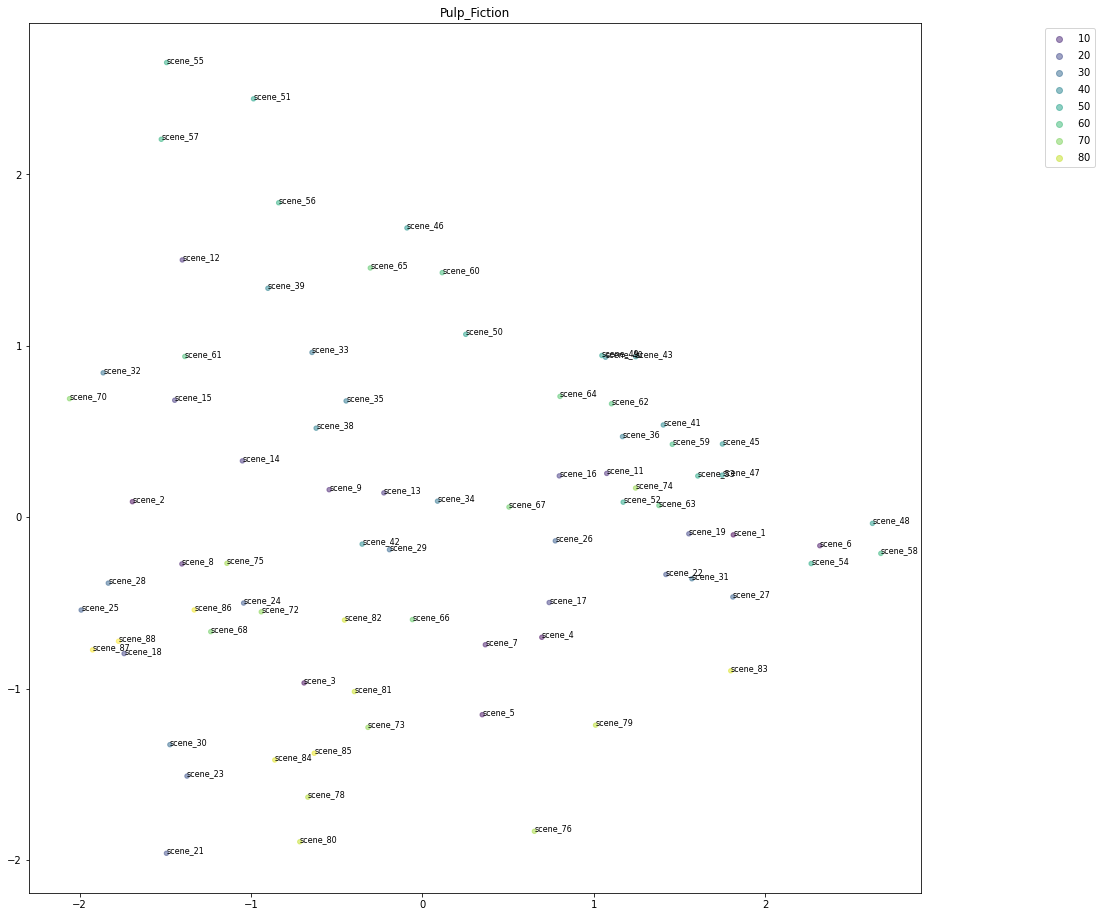

In [99]:
movie_emb = {}
positional = get_sinusoid_encoding_table(500,16)
for num, name in enumerate(tripod['movie_name']):
#    if name =='Slumdog Millionaire':
#        continue
    if name !='Soldier (1998 American film)':
        continue
    name = 'Pulp_Fiction'
    print(name)
    mov = Movie('../AligNarr/dataset/10_movies/'+name+ '/script_clean.txt')
    scene_embedding = {}
    total_embedding = []
    total_sentence = []
    
    for i, char_dict in mov.scene_dict.items():
        scene = {}
        for char, sent in char_dict.items():
            emb = make_embedding(sent)
            scene[char] = [emb,sent]       
            total_embedding += emb
            total_sentence +=sent
        scene_embedding[i] = scene

        
    emb_act = []
    g_list = []
    id_num = 1
    node_embedding = {}
    total_act = []
    for i, (scene, contents) in enumerate(scene_embedding.items()):
        #line = 'scene_' + str(scene) + '  ' + 'scene_' + str(scene+1) + '  ' + '1' + '  ' + str(id_num)
        #if i != len(scene_embedding_reduction.items())-1:
        #    g_list.append([line])
        #id_num +=1 
        sent_num = 1
        sentnum_emb = {}
        sentnum_sent = {}
        total_sent = 0
        for char, (embs,sent) in contents.items():
            total_sent += len(embs)
        for char, (embs,sent) in contents.items():   
            char_len = len(embs)
            for emb,s in zip(embs,sent):
                sentnum_emb[sent_num] = emb
                sentnum_sent[sent_num] = s
                line = 'scene_' + str(scene) + '  ' + str(scene) + '_act_' + str(sent_num) + '  ' + '2' + '  ' + str(id_num)
                total_act.append(str(scene) + '_act_' + str(sent_num))
                node_embedding[str(scene) + '_act_' + str(sent_num)] = np.concatenate((emb,np.zeros([16])))
                id_num += 1
                g_list.append([line])
                line = str(scene) + '_act_' + str(sent_num) + '  ' + 'char_' + char + '  ' + '3' + '  ' + str(id_num)
                id_num += 1
                sent_num += 1
                g_list.append([line])
        cn =0
        
        if sent_num!=1:     
            for j in range(1,sent_num):
                for k in range(j+1,sent_num):
                    if len(sentnum_sent[j])>25 and len(sentnum_sent[k])>25:
                        score = util.cos_sim(sentnum_emb[j],sentnum_emb[k])[0]
                        if score > 0.6 and score< 0.99:
                            #print(name, sentnum_sent[j])
                            node_embedding[str(scene) + '_act_' + str(j)] = np.concatenate((sentnum_emb[j][:384],positional[scene]))
                            node_embedding[str(scene) + '_act_' + str(k)] = np.concatenate((sentnum_emb[k][:384],positional[scene]))
                            line = str(scene) + '_act_' + str(j) + '  ' + str(scene) + '_act_' + str(k) + '  ' + '4' + '  ' + str(id_num)
                            id_num += 1
                            g_list.append([line])
                            cn = 1

            
            
    with open('test.csv', 'w',newline='') as f: 
        write = csv.writer(f)    
        write.writerows(g_list)
    g= read_graph('test.csv')
    attr = {}
    for node in g.nodes():
        if 'scene' in node:
            attr[node]='scene'
        elif 'act' in node:
            attr[node]='act'
        elif 'char' in node:
            attr[node]='char'
    nx.set_node_attributes(g, attr,"label")
    stellar_g = StellarGraph.from_networkx(g)
    stellar_g.info()
    
       # Create the random walker
    rw = UniformRandomMetaPathWalk(stellar_g)

    walks1 = rw.run(
        nodes=list(stellar_g.nodes()),  # root nodes
        length=walk_length,  # maximum length of a random walk
        n=2,  # number of random walks per root node
        metapaths=metapaths,  # the metapaths
    )
    walks2 = rw.run(
        nodes=list(stellar_g.nodes()),  # root nodes
        length=walk_length*2,  # maximum length of a random walk
        n=30,  # number of random walks per root node
        metapaths=metapaths2,  # the metapaths
    )
    walks3 = rw.run(
        nodes=list(stellar_g.nodes()),  # root nodes
        length=walk_length,  # maximum length of a random walk
        n=5,  # number of random walks per root node
        metapaths=metapaths3,  # the metapaths
    )

    walks = []
    for w in walks1:
        walks.append(w)
    for w in walks2:
        walks.append(w)
    for w in walks3:
        walks.append(w)

    print("Number of random walks: {}".format(len(walks))) 
    
    w2v = Word2Vec(vector_size=400, window=2, min_count=0, sg=1, workers=4, epochs=0)
    w2v.build_vocab(corpus_iterable=[list(g.nodes())])
    for key in w2v.wv.index_to_key:
        if key in node_embedding.keys():
            w2v.wv[key] = node_embedding[key]
            
    random.shuffle(walks)

    
    w2v.train(walks, total_examples=w2v.corpus_count, epochs=90)
    # Retrieve node embeddings and corresponding subjects
    node_ids = [i for i in w2v.wv.index_to_key if 'scene' in i]
    node_ids.sort()
    node_ids.sort(key=len)
    node_embeddings = (
        w2v.wv[node_ids]
    )  # numpy.ndarray of size number of nodes times embeddings dimensionality
    
    movie_emb[name] = [node_embeddings]
    
    node_targets = [stellar_g.node_type(node_id) for node_id in node_ids]
    node_embeddings_2d = trans.fit_transform(node_embeddings)
    #label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
    node_colours = [int(i[6:]) for i in node_ids]


    plt.figure(figsize=(20, 16))
    plt.axes().set(aspect="equal")
    X = node_embeddings_2d[:, 0]
    Y = node_embeddings_2d[:, 1]
    scatter = plt.scatter(X, Y, c=node_colours, alpha=0.5,s=20)
    plt.title(name)
    plt.legend(*scatter.legend_elements(), loc="upper right",bbox_to_anchor=(1.2, 1))
 #   for i, label in enumerate(node_ids):
 #       plt.annotate(label, (X[i], Y[i]))
    for i, label in enumerate(node_ids):
        plt.annotate(label, (X[i], Y[i]),fontsize=8)

    plt.savefig(name+'_scene_proceed.png',dpi=300)  
    plt.show()




In [ ]:
    
    main_char = mov.find_maincharacter_name(num=3)
    print(main_char)
    Xs = []
    Ys = []
    X_s = []
    Y_s = []
    real_pro = []
    for k, main in enumerate(main_char):
        node_colours = [0 for i in node_targets]
        pro = main_char[k]
        if pro in ['ALL','NARRATOR','GIRL','SAY']:
            continue
        pro_scene = []
        real_pro.append(pro)


        for i, char_dict in mov.scene_dict.items():
            if pro in char_dict.keys():
                pro_scene.append(i)

        for i in pro_scene:
            for num, node_id in enumerate(node_ids):
                if int(node_id[6:]) == i:
                    node_colours[num] = k+1
        #for i in pro_scene2:
        #    for num, node_id in enumerate(node_ids):
        #        if int(node_id[6:]) == i:
        #             node_colours[num] = 3
        #for i in set(pro_scene)&set(pro_scene2):
        #    for num, node_id in enumerate(node_ids):
        #        if int(node_id[6:]) == i:
        #             node_colours[num] = 2

        movie_emb[name] += [node_colours]
        color = 0
        last = 0

        plt.figure(figsize=(20, 16))
        plt.axes().set(aspect="equal")
        not_char = []
        yes_char = []
        for i, n_em in enumerate(node_embeddings_2d):
            if node_colours[i]:
                yes_char.append(n_em)
            else:
                not_char.append(n_em)
        X = np.array(not_char)[:, 0]
        Y = np.array(not_char)[:, 1]
        X_ = np.array(yes_char)[:,0]
        Y_  = np.array(yes_char)[:,1]
        Xs.append(X)
        Ys.append(Y)
        X_s.append(X_)
        Y_s.append(Y_)
        scatter = plt.scatter(X, Y, color = 'grey', alpha=0.5, label = 'Not Present')
        scatter = plt.scatter(X_, Y_, color = 'blue', alpha=0.5, label = 'Present')

        plt.title(name+' - '+pro)

        plt.legend(scatterpoints=1,loc="upper right")

        plt.savefig(name+'_'+ pro +'.png',dpi=300)  
        plt.show()


In [ ]:
    
    
    
    main_char = mov.find_maincharacter_name(num=3)
    print(main_char)
    Xs = []
    Ys = []
    X_s = []
    Y_s = []
    real_pro = []
    for k, main in enumerate(main_char):
        node_colours = [0 for i in node_targets]
        pro = main_char[k]
        if pro in ['ALL','NARRATOR','GIRL','SAY']:
            continue
        pro_scene = []
        real_pro.append(pro)


        for i, char_dict in mov.scene_dict.items():
            if pro in char_dict.keys():
                pro_scene.append(i)

        for i in pro_scene:
            for num, node_id in enumerate(node_ids):
                if int(node_id[6:]) == i:
                    node_colours[num] = k+1
        #for i in pro_scene2:
        #    for num, node_id in enumerate(node_ids):
        #        if int(node_id[6:]) == i:
        #             node_colours[num] = 3
        #for i in set(pro_scene)&set(pro_scene2):
        #    for num, node_id in enumerate(node_ids):
        #        if int(node_id[6:]) == i:
        #             node_colours[num] = 2

        movie_emb[name] += [node_colours]
        color = 0
        last = 0

        plt.figure(figsize=(5, 4))
        plt.axes().set(aspect="equal")
        not_char = []
        yes_char = []
        for i, n_em in enumerate(node_embeddings_2d):
            if node_colours[i]:
                yes_char.append(n_em)
            else:
                not_char.append(n_em)
        X = np.array(not_char)[:, 0]
        Y = np.array(not_char)[:, 1]
        X_ = np.array(yes_char)[:,0]
        Y_  = np.array(yes_char)[:,1]
        Xs.append(X)
        Ys.append(Y)
        X_s.append(X_)
        Y_s.append(Y_)
        scatter = plt.scatter(X, Y, color = 'grey', alpha=0.5, label = 'Not Present')
        scatter = plt.scatter(X_, Y_, color = 'blue', alpha=0.5, label = 'Present')

        plt.title(name+' - '+pro)

        plt.legend(scatterpoints=1,loc="upper right")

        plt.savefig(name+'_'+ pro +'.png',dpi=300)  
        plt.show()


In [35]:
colors = ['red','yellowgreen','lime','green']

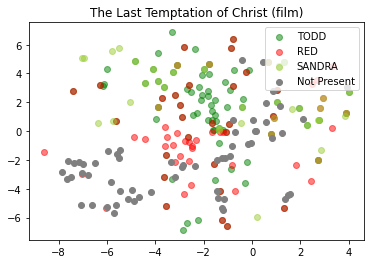

In [38]:
X_extra = []
Y_extra = []
for i in range(0,3):
    X = Xs[i]
    Y = Ys[i]
    X_ = X_s[i]
    Y_  = Y_s[i]
    X_extra.append(X)
    Y_extra.append(Y)
    scatter = plt.scatter(X_, Y_, color = colors[i-1], alpha=0.5, label = real_pro[i])
X = set(X_extra[0])&set(X_extra[1])&set(X_extra[2])
Y = set(Y_extra[0])&set(Y_extra[1])&set(Y_extra[2])
scatter = plt.scatter(list(X), list(Y), color = 'grey', alpha=1, label = 'Not Present')
plt.title(name)

plt.legend(scatterpoints=1,loc="upper right")

plt.savefig(name+'_char'+'.png',dpi=300)  
plt.show()

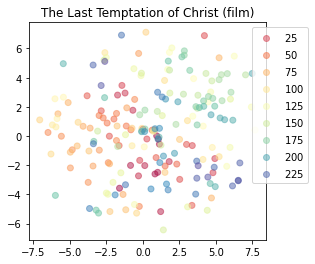

['TODD', 'RED', 'SANDRA']


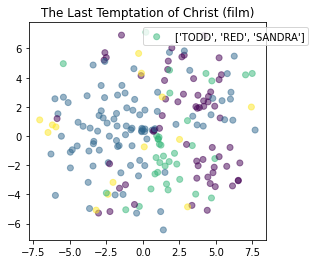

In [31]:
    node_colours = [int(i[6:]) for i in node_ids]


    plt.figure(figsize=(5, 4))
    plt.axes().set(aspect="equal")
    X = node_embeddings_2d[:, 0]
    Y = node_embeddings_2d[:, 1]
    scatter = plt.scatter(X, Y, c=node_colours, alpha=0.5,cmap='Spectral')
    plt.title(name)
    plt.legend(*scatter.legend_elements(), loc="upper right",bbox_to_anchor=(1.2, 1))
 #   for i, label in enumerate(node_ids):
 #       plt.annotate(label, (X[i], Y[i]))

    plt.savefig(name+'_scene_proceed.png',dpi=300)  
    plt.show()
    
    
    
    main_char = mov.find_maincharacter_name(num=3)
    print(main_char)

    for i, char_dict in mov.scene_dict.items():
        if main_char[0] in char_dict.keys():
            pro_scene1.append(i)
    for i, char_dict in mov.scene_dict.items():
        if main_char[1] in char_dict.keys():
            pro_scene2.append(i)
    for i, char_dict in mov.scene_dict.items():
        if main_char[2] in char_dict.keys():
            pro_scene3.append(i)
    node_colours = [0 for i in node_targets]
    for i in pro_scene3:
        for num, node_id in enumerate(node_ids):
            if int(node_id[6:]) == i:
                node_colours[num] = 3
    for i in pro_scene2:
        for num, node_id in enumerate(node_ids):
            if int(node_id[6:]) == i:
                node_colours[num] = 2
    for i in pro_scene1:
        for num, node_id in enumerate(node_ids):
            if int(node_id[6:]) == i:
                node_colours[num] = 1
    plt.figure(figsize=(5, 4))
    plt.axes().set(aspect="equal")
    X = node_embeddings_2d[:, 0]
    Y = node_embeddings_2d[:, 1]
    scatter = plt.scatter(X, Y, c=node_colours, alpha=0.5,cmap='viridis', label=['TODD', 'RED', 'SANDRA'])
    plt.title(name)
    plt.legend( loc="upper right",bbox_to_anchor=(1.2, 1))
 #   for i, label in enumerate(node_ids):
 #       plt.annotate(label, (X[i], Y[i]))

    plt.savefig(name+'_char.png',dpi=300)  
    plt.show()

In [26]:
scatter.legend_elements()

([<matplotlib.lines.Line2D at 0x7ff5649a64c0>,
 ['$\\mathdefault{0}$',
  '$\\mathdefault{1}$',
  '$\\mathdefault{2}$',
  '$\\mathdefault{3}$'])

The Back-up Plan
Number of random walks: 8350


/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


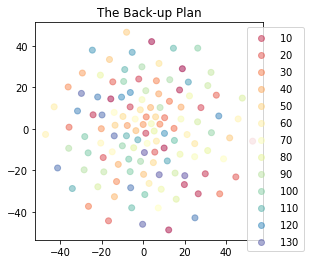

The Shining (film)
Number of random walks: 8535


/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


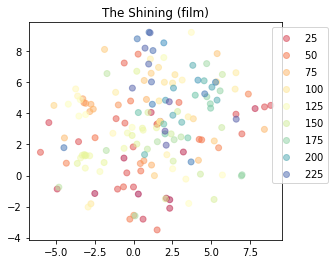

Juno (film)
Number of random walks: 6537


/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


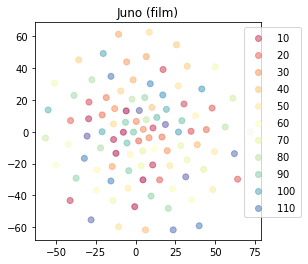

Soldier (1998 American film)
Number of random walks: 9907


/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


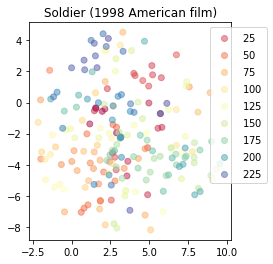

Panic Room
Number of random walks: 5928


/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


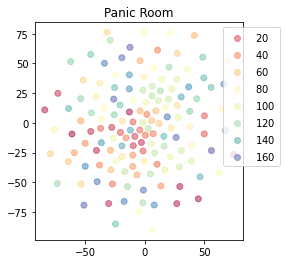

Arbitrage (film)
Number of random walks: 8166


/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


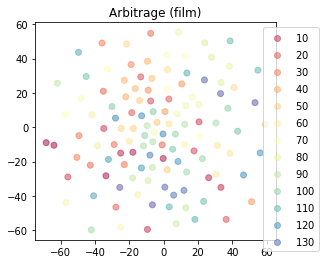

The Breakfast Club
Number of random walks: 4667


/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


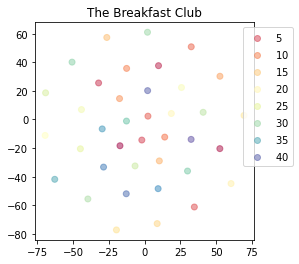

Slumdog Millionaire
Number of random walks: 10052


/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


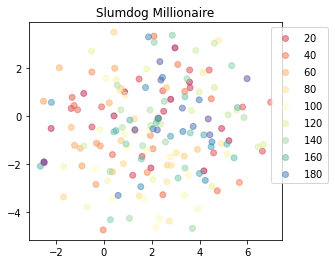

Total Recall (1990 film)
Number of random walks: 10174


/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


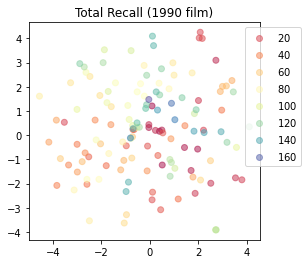

Unforgiven
Number of random walks: 8012


/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


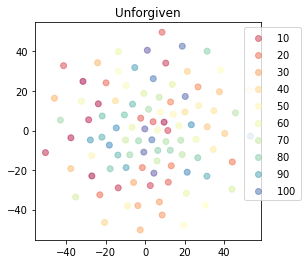

Die Hard
Number of random walks: 8103


/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


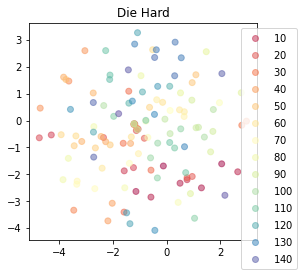

Moon (film)
Number of random walks: 6084


/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


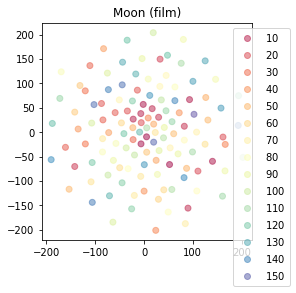

One Eight Seven
Number of random walks: 7993


/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


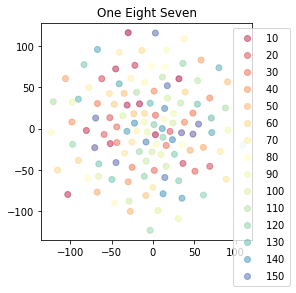

The Crying Game
Number of random walks: 7348


/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


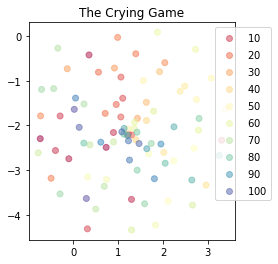

The Last Temptation of Christ (film)
Number of random walks: 7861


/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


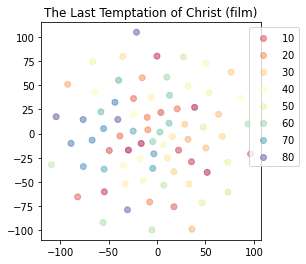

In [21]:
movie_emb = {}
positional = get_sinusoid_encoding_table(500,16)
for num, name in enumerate(tripod['movie_name']):
#    if name =='Slumdog Millionaire':
#        continue
#    if num ==5:
#        break

    print(name)
    tps = {}
    for i in range(1,6): 
        tp = [tp.replace('[','').replace(']','').split(', ') for tp in tripod[tripod['movie_name']==name]['tp'+str(i)].values]
        tp = list(map(int, tp[0]))
        tps['tp'+str(i)] = tp
    mov = Movie('Segmented_screenplays/'+name+'_script_segmented.txt')
    scene_embedding = {}
    total_embedding = []
    total_sentence = []
    
    for i, char_dict in mov.scene_dict.items():
        scene = {}
        for char, sent in char_dict.items():
            emb = make_embedding(sent)
            scene[char] = [emb,sent]       
            total_embedding += emb
            total_sentence +=sent
        scene_embedding[i] = scene

        
    emb_act = []
    g_list = []
    id_num = 1
    node_embedding = {}
    total_act = []
    for i, (scene, contents) in enumerate(scene_embedding.items()):
        #line = 'scene_' + str(scene) + '  ' + 'scene_' + str(scene+1) + '  ' + '1' + '  ' + str(id_num)
        #if i != len(scene_embedding_reduction.items())-1:
        #    g_list.append([line])
        #id_num +=1 
        sent_num = 1
        sentnum_emb = {}
        sentnum_sent = {}
        total_sent = 0
        for char, (embs,sent) in contents.items():
            total_sent += len(embs)
        for char, (embs,sent) in contents.items():   
            char_len = len(embs)
            for emb,s in zip(embs,sent):
                sentnum_emb[sent_num] = emb
                sentnum_sent[sent_num] = s
                line = 'scene_' + str(scene) + '  ' + str(scene) + '_act_' + str(sent_num) + '  ' + '2' + '  ' + str(id_num)
                total_act.append(str(scene) + '_act_' + str(sent_num))
                node_embedding[str(scene) + '_act_' + str(sent_num)] = np.concatenate((emb,np.zeros([16])))
                id_num += 1
                g_list.append([line])
                line = str(scene) + '_act_' + str(sent_num) + '  ' + 'char_' + char + '  ' + '3' + '  ' + str(id_num)
                id_num += 1
                sent_num += 1
                g_list.append([line])
        cn =0
        
        if sent_num!=1:     
            for j in range(1,sent_num):
                for k in range(j+1,sent_num):
                    if len(sentnum_sent[j])>25 and len(sentnum_sent[k])>25:
                        score = util.cos_sim(sentnum_emb[j],sentnum_emb[k])[0]
                        if score > 0.6 and score< 0.99:
                            #print(name, sentnum_sent[j])
                            node_embedding[str(scene) + '_act_' + str(j)] = np.concatenate((sentnum_emb[j][:384],positional[scene]))
                            node_embedding[str(scene) + '_act_' + str(k)] = np.concatenate((sentnum_emb[k][:384],positional[scene]))
                            line = str(scene) + '_act_' + str(j) + '  ' + str(scene) + '_act_' + str(k) + '  ' + '4' + '  ' + str(id_num)
                            id_num += 1
                            g_list.append([line])
                            cn = 1

            
            
    with open('test.csv', 'w',newline='') as f: 
        write = csv.writer(f)    
        write.writerows(g_list)
    g= read_graph('test.csv')
    attr = {}
    for node in g.nodes():
        if 'scene' in node:
            attr[node]='scene'
        elif 'act' in node:
            attr[node]='act'
        elif 'char' in node:
            attr[node]='char'
    nx.set_node_attributes(g, attr,"label")
    stellar_g = StellarGraph.from_networkx(g)
    stellar_g.info()
    
       # Create the random walker
    rw = UniformRandomMetaPathWalk(stellar_g)

    walks1 = rw.run(
        nodes=list(stellar_g.nodes()),  # root nodes
        length=walk_length,  # maximum length of a random walk
        n=2,  # number of random walks per root node
        metapaths=metapaths,  # the metapaths
    )
    walks2 = rw.run(
        nodes=list(stellar_g.nodes()),  # root nodes
        length=walk_length*2,  # maximum length of a random walk
        n=30,  # number of random walks per root node
        metapaths=metapaths2,  # the metapaths
    )
    walks3 = rw.run(
        nodes=list(stellar_g.nodes()),  # root nodes
        length=walk_length,  # maximum length of a random walk
        n=5,  # number of random walks per root node
        metapaths=metapaths3,  # the metapaths
    )

    walks = []
    for w in walks1:
        walks.append(w)
    for w in walks2:
        walks.append(w)
    for w in walks3:
        walks.append(w)

    print("Number of random walks: {}".format(len(walks))) 
    
    w2v = Word2Vec(vector_size=400, window=2, min_count=0, sg=1, workers=4, epochs=0)
    w2v.build_vocab(corpus_iterable=[list(g.nodes())])
    for key in w2v.wv.index_to_key:
        if key in node_embedding.keys():
            w2v.wv[key] = node_embedding[key]
            
    random.shuffle(walks)

    
    w2v.train(walks, total_examples=w2v.corpus_count, epochs=90)
    # Retrieve node embeddings and corresponding subjects
    node_ids = [i for i in w2v.wv.index_to_key if 'scene' in i]
    node_ids.sort()
    node_ids.sort(key=len)
    node_embeddings = (
        w2v.wv[node_ids]
    )  # numpy.ndarray of size number of nodes times embeddings dimensionality
    
    movie_emb[name] = [node_embeddings]
    
    node_targets = [stellar_g.node_type(node_id) for node_id in node_ids]
    node_embeddings_2d = trans.fit_transform(node_embeddings)
    #label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
    node_colours = [int(i[6:]) for i in node_ids]
    movie_emb[name] += [node_colours]
    color = 0
    last = 0
    #print(len(node_ids), len(node_colours))

    plt.figure(figsize=(5, 4))
    plt.axes().set(aspect="equal")
    X = node_embeddings_2d[:, 0]
    Y = node_embeddings_2d[:, 1]
    scatter = plt.scatter(X, Y, c=node_colours, alpha=0.5,cmap='Spectral')
    plt.title(name)
    plt.legend(*scatter.legend_elements(), loc="upper right",bbox_to_anchor=(1.2, 1))
 #   for i, label in enumerate(node_ids):
 #       plt.annotate(label, (X[i], Y[i]))

    plt.savefig(name+'_pca.png',dpi=300)  
    plt.show()

The Back-up Plan
Number of random walks: 8447
[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6]


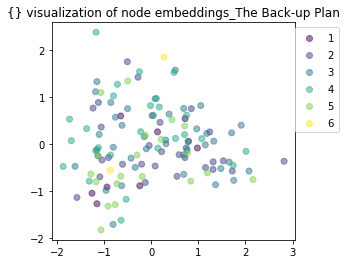

The Shining (film)
Number of random walks: 8826
[1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6]


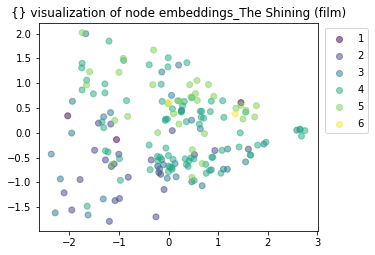

Juno (film)
Number of random walks: 6571
[1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]


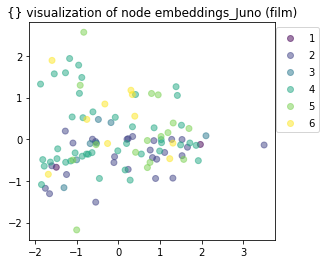

Soldier (1998 American film)
Number of random walks: 9883
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6]


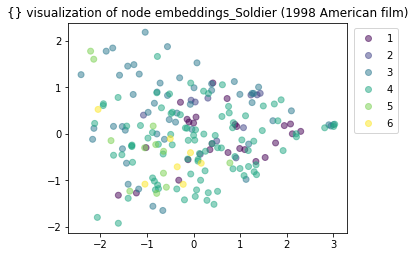

Panic Room
Number of random walks: 5983
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6]


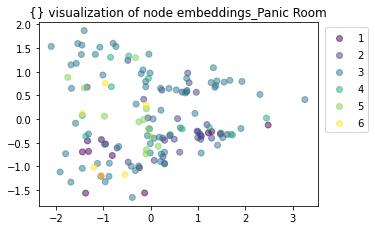

Arbitrage (film)
Number of random walks: 8013
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5]


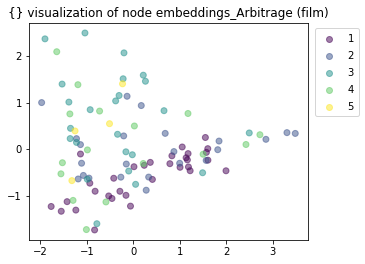

The Breakfast Club
Number of random walks: 4682
[1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6]


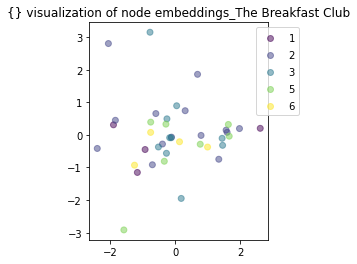

Slumdog Millionaire
Number of random walks: 9960
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6]


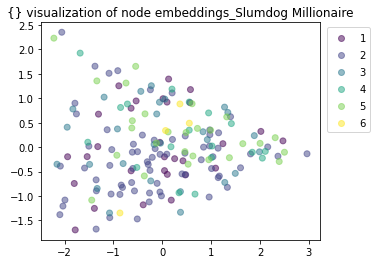

Total Recall (1990 film)
Number of random walks: 10157
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6]


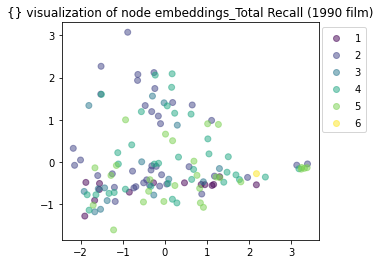

Unforgiven
Number of random walks: 8115
[1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6]


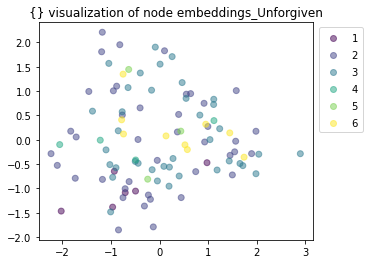

Die Hard
Number of random walks: 8024
[1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 6, 6]


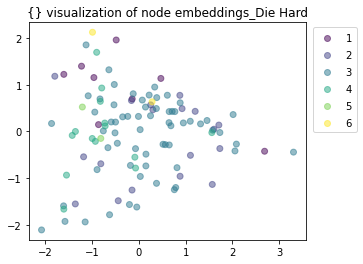

Moon (film)
Number of random walks: 6041
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6]


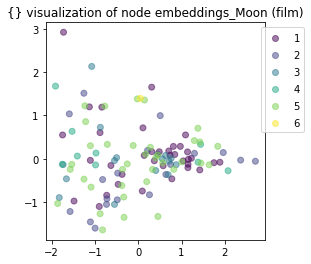

One Eight Seven
Number of random walks: 7963
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6]


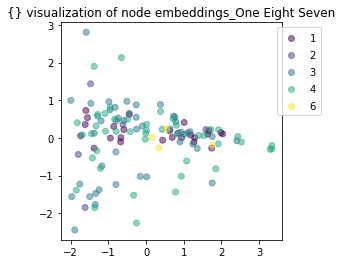

The Crying Game
Number of random walks: 7650
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6]


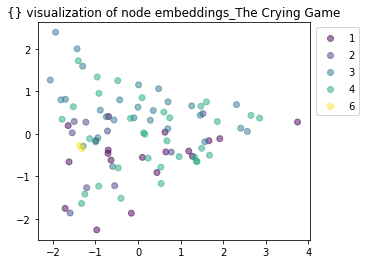

The Last Temptation of Christ (film)
Number of random walks: 7848
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 6, 6]


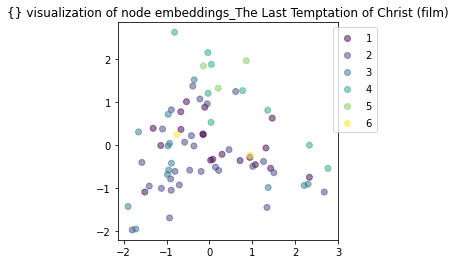

In [57]:
movie_emb = {}
positional = get_sinusoid_encoding_table(500,16)
for num, name in enumerate(tripod['movie_name']):
#    if name =='Slumdog Millionaire':
#        continue
#    if num ==5:
#        break

    print(name)
    tps = {}
    for i in range(1,6): 
        tp = [tp.replace('[','').replace(']','').split(', ') for tp in tripod[tripod['movie_name']==name]['tp'+str(i)].values]
        tp = list(map(int, tp[0]))
        tps['tp'+str(i)] = tp
    mov = Movie('Segmented_screenplays/'+name+'_script_segmented.txt')
    scene_embedding = {}
    total_embedding = []
    total_sentence = []
    
    for i, char_dict in mov.scene_dict.items():
        scene = {}
        for char, sent in char_dict.items():
            emb = make_embedding(sent)
            scene[char] = [emb,sent]       
            total_embedding += emb
            total_sentence +=sent
        scene_embedding[i] = scene

        
    emb_act = []
    g_list = []
    id_num = 1
    node_embedding = {}
    total_act = []
    for i, (scene, contents) in enumerate(scene_embedding.items()):
        #line = 'scene_' + str(scene) + '  ' + 'scene_' + str(scene+1) + '  ' + '1' + '  ' + str(id_num)
        #if i != len(scene_embedding_reduction.items())-1:
        #    g_list.append([line])
        #id_num +=1 
        sent_num = 1
        sentnum_emb = {}
        sentnum_sent = {}
        total_sent = 0
        for char, (embs,sent) in contents.items():
            total_sent += len(embs)
        for char, (embs,sent) in contents.items():   
            char_len = len(embs)
            for emb,s in zip(embs,sent):
                sentnum_emb[sent_num] = emb
                sentnum_sent[sent_num] = s
                line = 'scene_' + str(scene) + '  ' + str(scene) + '_act_' + str(sent_num) + '  ' + '2' + '  ' + str(id_num)
                total_act.append(str(scene) + '_act_' + str(sent_num))
                node_embedding[str(scene) + '_act_' + str(sent_num)] = np.concatenate((emb,np.zeros([16])))
                id_num += 1
                g_list.append([line])
                line = str(scene) + '_act_' + str(sent_num) + '  ' + 'char_' + char + '  ' + '3' + '  ' + str(id_num)
                id_num += 1
                sent_num += 1
                g_list.append([line])
        cn =0
        
        if sent_num!=1:     
            for j in range(1,sent_num):
                for k in range(j+1,sent_num):
                    if len(sentnum_sent[j])>25 and len(sentnum_sent[k])>25:
                        score = util.cos_sim(sentnum_emb[j],sentnum_emb[k])[0]
                        if score > 0.6 and score< 0.99:
                            #print(name, sentnum_sent[j])
                            node_embedding[str(scene) + '_act_' + str(j)] = np.concatenate((sentnum_emb[j][:384],positional[scene]))
                            node_embedding[str(scene) + '_act_' + str(k)] = np.concatenate((sentnum_emb[k][:384],positional[scene]))
                            line = str(scene) + '_act_' + str(j) + '  ' + str(scene) + '_act_' + str(k) + '  ' + '4' + '  ' + str(id_num)
                            id_num += 1
                            g_list.append([line])
                            cn = 1

            
            
    with open('test.csv', 'w',newline='') as f: 
        write = csv.writer(f)    
        write.writerows(g_list)
    g= read_graph('test.csv')
    attr = {}
    for node in g.nodes():
        if 'scene' in node:
            attr[node]='scene'
        elif 'act' in node:
            attr[node]='act'
        elif 'char' in node:
            attr[node]='char'
    nx.set_node_attributes(g, attr,"label")
    stellar_g = StellarGraph.from_networkx(g)
    stellar_g.info()
    
       # Create the random walker
    rw = UniformRandomMetaPathWalk(stellar_g)

    walks1 = rw.run(
        nodes=list(stellar_g.nodes()),  # root nodes
        length=walk_length,  # maximum length of a random walk
        n=2,  # number of random walks per root node
        metapaths=metapaths,  # the metapaths
    )
    walks2 = rw.run(
        nodes=list(stellar_g.nodes()),  # root nodes
        length=walk_length*2,  # maximum length of a random walk
        n=30,  # number of random walks per root node
        metapaths=metapaths2,  # the metapaths
    )
    walks3 = rw.run(
        nodes=list(stellar_g.nodes()),  # root nodes
        length=walk_length,  # maximum length of a random walk
        n=5,  # number of random walks per root node
        metapaths=metapaths3,  # the metapaths
    )

    walks = []
    for w in walks1:
        walks.append(w)
    for w in walks2:
        walks.append(w)
    for w in walks3:
        walks.append(w)

    print("Number of random walks: {}".format(len(walks))) 
    
    w2v = Word2Vec(vector_size=400, window=2, min_count=0, sg=1, workers=4, epochs=0)
    w2v.build_vocab(corpus_iterable=[list(g.nodes())])
    for key in w2v.wv.index_to_key:
        if key in node_embedding.keys():
            w2v.wv[key] = node_embedding[key]
            
    random.shuffle(walks)

    
    w2v.train(walks, total_examples=w2v.corpus_count, epochs=90)
    # Retrieve node embeddings and corresponding subjects
    node_ids = [i for i in w2v.wv.index_to_key if 'scene' in i]
    node_ids.sort()
    node_ids.sort(key=len)
    node_embeddings = (
        w2v.wv[node_ids]
    )  # numpy.ndarray of size number of nodes times embeddings dimensionality
    
    movie_emb[name] = [node_embeddings]
    
    node_targets = [stellar_g.node_type(node_id) for node_id in node_ids]
    node_embeddings_2d = trans.fit_transform(node_embeddings)
    #label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
    node_colours = [0 for i in node_targets]
    movie_emb[name] += [node_colours]
    color = 0
    last = 0
    #print(len(node_ids), len(node_colours))
    for i, value in enumerate(tps.values()):
        for val in value:
            for j, node in enumerate(node_ids):
                if int(node[6:])<val and int(node[6:])>=last:
                    node_colours[j] = i+1
        last = val
        color += 5
    for k in range(len(node_colours)-1,0,-1):
        if node_colours[k] != 0:
            break
        node_colours[k] = i+2
    print(node_colours)
    plt.figure(figsize=(5, 4))
    plt.axes().set(aspect="equal")
    X = node_embeddings_2d[:, 0]
    Y = node_embeddings_2d[:, 1]
    scatter = plt.scatter(X, Y, c=node_colours, alpha=0.5)
    plt.title("{} visualization of node embeddings_"+name.format(transform.__name__))
    plt.legend(*scatter.legend_elements(), loc="upper right",bbox_to_anchor=(1.2, 1))
 #   for i, label in enumerate(node_ids):
 #       plt.annotate(label, (X[i], Y[i]))

    plt.savefig(name+'_pca.png',dpi=300)  
    plt.show()

In [55]:
transform = PCA  # PCA

trans = transform(n_components=2)

The Back-up Plan
Number of random walks: 8150
[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6]


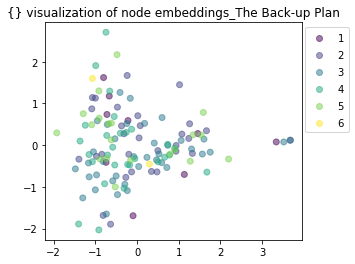

The Shining (film)
Number of random walks: 8388
[1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6]


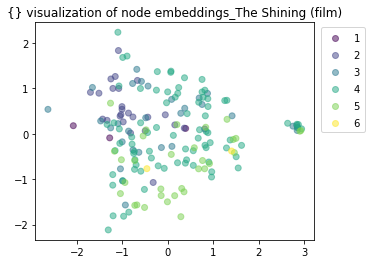

Juno (film)
Number of random walks: 6346
[1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]


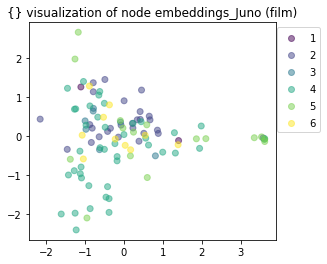

Soldier (1998 American film)
Number of random walks: 9454
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6]


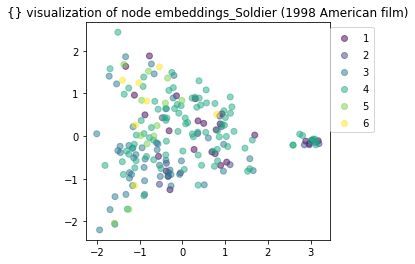

Panic Room
Number of random walks: 5758
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6]


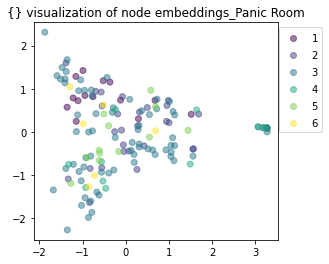

Arbitrage (film)
Number of random walks: 7654
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5]


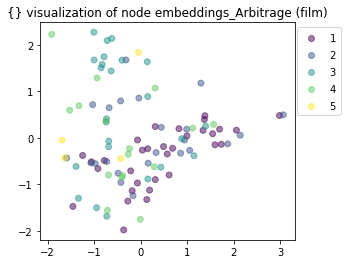

The Breakfast Club
Number of random walks: 4588
[1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6]


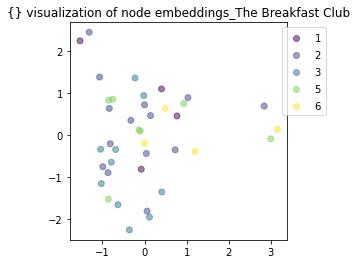

Slumdog Millionaire
Number of random walks: 9500
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6]


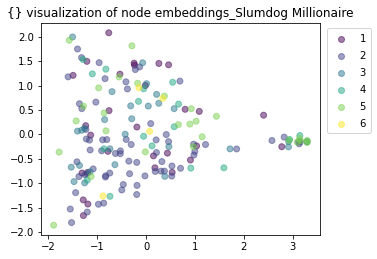

Total Recall (1990 film)
Number of random walks: 9706
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6]


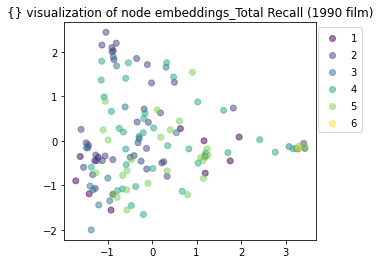

Unforgiven
Number of random walks: 7814
[1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6]


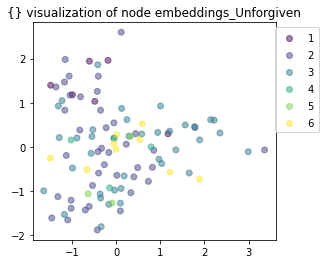

Die Hard
Number of random walks: 7572
[1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 6, 6]


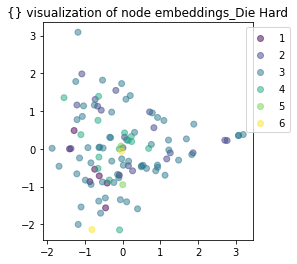

Moon (film)
Number of random walks: 5794
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6]


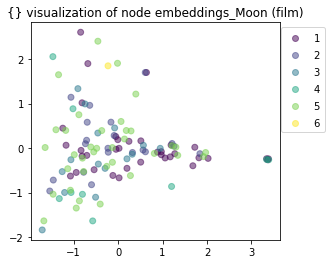

One Eight Seven
Number of random walks: 7590
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6]


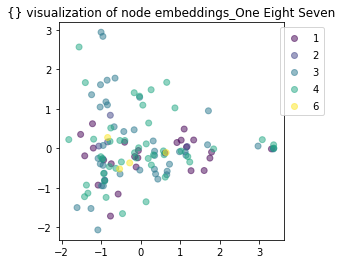

The Crying Game
Number of random walks: 7464
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6]


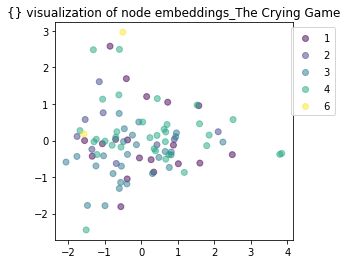

The Last Temptation of Christ (film)
Number of random walks: 7504
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 6, 6]


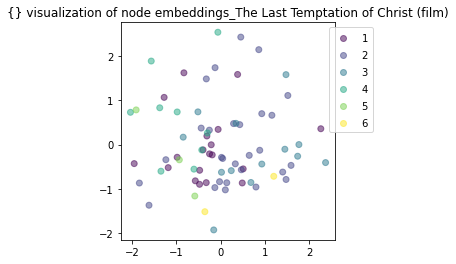

In [32]:
movie_emb = {}
for num, name in enumerate(tripod['movie_name']):
#    if name =='Slumdog Millionaire':
#        continue
#    if num ==5:
#        break

    print(name)
    tps = {}
    for i in range(1,6): 
        tp = [tp.replace('[','').replace(']','').split(', ') for tp in tripod[tripod['movie_name']==name]['tp'+str(i)].values]
        tp = list(map(int, tp[0]))
        tps['tp'+str(i)] = tp
    mov = Movie('Segmented_screenplays/'+name+'_script_segmented.txt')
    scene_embedding = {}
    total_embedding = []
    total_sentence = []
    
    for i, char_dict in mov.scene_dict.items():
        scene = {}
        for char, sent in char_dict.items():
            emb = make_embedding(sent)
            scene[char] = emb        
            total_embedding += emb
            total_sentence +=sent
        scene_embedding[i] = scene
    kernel, bias = compute_kernel_bias([total_embedding])
    scene_embedding_reduction = {}
    total_red_embedding = []
    for i, char_dict in scene_embedding.items():
        scene = {}
        for char, emb in char_dict.items():
            #re_emb = Dim_reduction(emb, kernel, bias)
            re_emb= emb
            scene[char] = re_emb
            for r_e in re_emb:
                total_red_embedding.append(r_e)                
        scene_embedding_reduction[i] = scene
        
            
        
    
    
    emb_act = []
    g_list = []
    id_num = 1
    node_embedding = {}
    total_act = []
    for i, (scene, contents) in enumerate(scene_embedding_reduction.items()):
            #line = 'scene_' + str(scene) + '  ' + 'scene_' + str(scene+1) + '  ' + '1' + '  ' + str(id_num)
            #if i != len(scene_embedding_reduction.items())-1:
            #    g_list.append([line])
            #id_num +=1 
        sent_num = 1
        for char, embs in contents.items():        
            for emb in embs:
                line = 'scene_' + str(scene) + '  ' + str(scene) + '_act_' + str(sent_num) + '  ' + '2' + '  ' + str(id_num)
                total_act.append(str(scene) + '_act_' + str(sent_num))
                node_embedding[str(scene) + '_act_' + str(sent_num)] = emb
                emb_act.append([emb,str(scene) + '_act_' + str(sent_num)])
                id_num += 1
                g_list.append([line])
                line = str(scene) + '_act_' + str(sent_num) + '  ' + 'char_' + char + '  ' + '3' + '  ' + str(id_num)
                id_num += 1
                sent_num += 1
                g_list.append([line])
        if sent_num!=1:     
            for j in range(sent_num):
                for k in range(j+1,sent_num):
                    line = str(scene) + '_act_' + str(j) + '  ' + str(scene) + '_act_' + str(k) + '  ' + '4' + '  ' + str(id_num)
                    id_num += 1
                    g_list.append([line])

            
            
    with open('test.csv', 'w',newline='') as f: 
        write = csv.writer(f)    
        write.writerows(g_list)
    g= read_graph('test.csv')
    attr = {}
    for node in g.nodes():
        if 'scene' in node:
            attr[node]='scene'
        elif 'act' in node:
            attr[node]='act'
        elif 'char' in node:
            attr[node]='char'
    nx.set_node_attributes(g, attr,"label")
    stellar_g = StellarGraph.from_networkx(g)
    stellar_g.info()
    
       # Create the random walker
    rw = UniformRandomMetaPathWalk(stellar_g)

    walks1 = rw.run(
        nodes=list(stellar_g.nodes()),  # root nodes
        length=walk_length,  # maximum length of a random walk
        n=2,  # number of random walks per root node
        metapaths=metapaths,  # the metapaths
    )

    walks2 = rw.run(
        nodes=list(stellar_g.nodes()),  # root nodes
        length=walk_length*2,  # maximum length of a random walk
        n=30,  # number of random walks per root node
        metapaths=metapaths2,  # the metapaths
    )

    walks = []
    for w in walks1:
        walks.append(w)
    for w in walks2:
            walks.append(w)


    print("Number of random walks: {}".format(len(walks))) 
    
    w2v = Word2Vec(vector_size=384, window=5, min_count=0, sg=1, workers=4, epochs=0)
    w2v.build_vocab(corpus_iterable=[list(g.nodes())])
    for key in w2v.wv.index_to_key:
        if key in node_embedding.keys():
            w2v.wv[key] = node_embedding[key]
            
    random.shuffle(walks)

    
    w2v.train(walks, total_examples=w2v.corpus_count, epochs=90)
    # Retrieve node embeddings and corresponding subjects
    node_ids = [i for i in w2v.wv.index_to_key if 'scene' in i]
    node_ids.sort()
    node_ids.sort(key=len)
    node_embeddings = (
        w2v.wv[node_ids]
    )  # numpy.ndarray of size number of nodes times embeddings dimensionality
    
    movie_emb[name] = [node_embeddings]
    
    node_targets = [stellar_g.node_type(node_id) for node_id in node_ids]
    node_embeddings_2d = trans.fit_transform(node_embeddings)
    #label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
    node_colours = [0 for i in node_targets]
    movie_emb[name] += [node_colours]
    color = 0
    last = 0
    #print(len(node_ids), len(node_colours))
    for i, value in enumerate(tps.values()):
        for val in value:
            for j, node in enumerate(node_ids):
                if int(node[6:])<val and int(node[6:])>=last:
                    node_colours[j] = i+1
        last = val
        color += 5
    for k in range(len(node_colours)-1,0,-1):
        if node_colours[k] != 0:
            break
        node_colours[k] = i+2
    print(node_colours)
    plt.figure(figsize=(5, 4))
    plt.axes().set(aspect="equal")
    X = node_embeddings_2d[:, 0]
    Y = node_embeddings_2d[:, 1]
    scatter = plt.scatter(X, Y, c=node_colours, alpha=0.5)
    plt.title("{} visualization of node embeddings_"+name.format(transform.__name__))
    plt.legend(*scatter.legend_elements(), loc="upper right",bbox_to_anchor=(1.2, 1))
 #   for i, label in enumerate(node_ids):
 #       plt.annotate(label, (X[i], Y[i]))

    plt.savefig(name+'_pca.png',dpi=300)  
    plt.show()

In [122]:
movie_emb = {}
for num, name in enumerate(tripod['movie_name']):
    if name =='Slumdog Millionaire':
        continue
    if num ==5:
        break

    print(name)
    tps = {}
    for i in range(1,6): 
        tp = [tp.replace('[','').replace(']','').split(', ') for tp in tripod[tripod['movie_name']==name]['tp'+str(i)].values]
        tp = list(map(int, tp[0]))
        tps['tp'+str(i)] = tp
    mov = Movie('Segmented_screenplays/'+name+'_script_segmented.txt')
    scene_embedding = {}
    total_embedding = []
    total_sentence = []
    
    for i, char_dict in mov.scene_dict.items():
        scene = {}
        for char, sent in char_dict.items():
            emb = make_embedding(sent)
            scene[char] = emb        
            total_embedding += emb
            total_sentence +=sent
        scene_embedding[i] = scene
    kernel, bias = compute_kernel_bias([total_embedding])
    scene_embedding_reduction = {}
    total_red_embedding = []
    for i, char_dict in scene_embedding.items():
        scene = {}
        for char, emb in char_dict.items():
            #re_emb = Dim_reduction(emb, kernel, bias)
            re_emb = emb
            scene[char] = re_emb
            for r_e in re_emb:
                total_red_embedding.append(r_e)
                
        scene_embedding_reduction[i] = scene
    g_list = []
    id_num = 1
    node_embedding = {}
    total_act = []
    for i, (scene, contents) in enumerate(scene_embedding_reduction.items()):
        #line = 'scene_' + str(scene) + '  ' + 'scene_' + str(scene+1) + '  ' + '1' + '  ' + str(id_num)
        #if i != len(scene_embedding_reduction.items())-1:
        #    g_list.append([line])
        #id_num +=1 
        sent_num = 1
        for char, embs in contents.items():        
            for emb in embs:
                line = 'scene_' + str(scene) + '  ' + str(scene) + '_act_' + str(sent_num) + '  ' + '2' + '  ' + str(id_num)
                total_act.append(str(scene) + '_act_' + str(sent_num))
                node_embedding[str(scene) + '_act_' + str(sent_num)] = emb
                id_num += 1
                g_list.append([line])
                line = str(scene) + '_act_' + str(sent_num) + '  ' + char + '  ' + '3' + '  ' + str(id_num)
                id_num += 1
                sent_num += 1
                g_list.append([line])
        if sent_num!=1:     
            for j in range(sent_num):
                for k in range(j+1,sent_num):
                    line = str(scene) + '_act_' + str(j) + '  ' + str(scene) + '_act_' + str(k) + '  ' + '4' + '  ' + str(id_num)
                    id_num += 1
                    g_list.append([line])    
    with open('test.csv', 'w',newline='') as f: 
        write = csv.writer(f)    
        write.writerows(g_list)
    g= read_graph('test.csv')
    attr = {}
    for node in g.nodes():
        if 'scene' in node:
            attr[node]='scene'
        elif 'act' in node:
            attr[node]='act'
        elif 'char' in node:
            attr[node]='char'
    nx.set_node_attributes(g, attr,"label")
    stellar_g = StellarGraph.from_networkx(g)
    stellar_g.info()
    
       # Create the random walker
    rw = UniformRandomMetaPathWalk(stellar_g)

    walks = rw.run(
        nodes=list(stellar_g.nodes()),  # root nodes
        length=walk_length,  # maximum length of a random walk
        n=1,  # number of random walks per root node
        metapaths=metapaths,  # the metapaths
    )

    print("Number of random walks: {}".format(len(walks))) 
    
    w2v = Word2Vec(vector_size=384, window=5, min_count=0, sg=1, workers=4, epochs=0)
    w2v.build_vocab(corpus_iterable=[list(g.nodes())])
    for key in w2v.wv.index_to_key:
        if key in node_embedding.keys():
            w2v.wv[key] = node_embedding[key]
    
    w2v.train(walks, total_examples=w2v.corpus_count, epochs=60)
    # Retrieve node embeddings and corresponding subjects
    node_ids = [i for i in w2v.wv.index_to_key if 'scene' in i]
    node_ids.sort()
    node_ids.sort(key=len)
    node_embeddings = (
        w2v.wv[node_ids]
    )  # numpy.ndarray of size number of nodes times embeddings dimensionality
    
    movie_emb[name] = [node_embeddings]
    
    node_targets = [stellar_g.node_type(node_id) for node_id in node_ids]
    node_embeddings_2d = trans.fit_transform(node_embeddings)
    label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
    node_colours = [label_map[target] for target in node_targets]
    movie_emb[name] += [node_colours]
    for i, value in enumerate(tps.values()):
        for val in value:
            node_colours[val-1] = i+1 
    plt.figure(figsize=(20, 16))
    plt.axes().set(aspect="equal")
    X = node_embeddings_2d[:, 0]
    Y = node_embeddings_2d[:, 1]
    plt.scatter(X, Y, c=node_colours, alpha=0.5)
    plt.title("{} visualization of node embeddings_"+name.format(transform.__name__))
    for i, label in enumerate(node_ids):
        plt.annotate(label, (X[i], Y[i]))

    plt.savefig(name+'.png',dpi=300)  
    plt.show()

The Back-up Plan
Number of random walks: 3438


/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


IndexError: list assignment index out of range

In [77]:
w2v = Word2Vec(vector_size=64, window=5, min_count=0, sg=1, workers=4, epochs=15)
w2v.build_vocab(corpus_iterable=[list(g.nodes())])

In [81]:
w2v.wv['scene_1']

array([-7.68136606e-03, -7.62251578e-03, -5.00131398e-04,  3.94004956e-03,
       -5.58035448e-04,  1.27886795e-03, -2.65233964e-03,  5.29050454e-03,
       -5.26886061e-03, -5.14007919e-03, -6.81447797e-03, -4.35712747e-03,
        2.98466906e-03,  1.92976370e-03, -3.01169045e-03,  5.85049391e-04,
        4.89625894e-03, -4.57839668e-03,  1.60507858e-03,  1.80518255e-04,
       -4.74523008e-03, -1.96616538e-03, -1.80274248e-04,  6.39664754e-03,
       -1.93402171e-03, -6.44628145e-03,  1.20248646e-04,  4.82477993e-03,
        3.50212865e-03,  6.72735088e-03,  1.45723112e-03, -3.33727710e-03,
        1.61790848e-03,  5.75282238e-03, -5.82161732e-03, -6.27022982e-03,
        1.97101757e-03, -4.44670022e-03, -5.96695393e-03,  4.52985987e-03,
       -7.58726895e-03,  3.54717858e-03, -7.24134594e-03, -2.00956129e-03,
        4.75589558e-03, -4.74410690e-03, -6.22287206e-03,  1.95537321e-03,
       -2.27756053e-03, -9.53337178e-04,  9.76216048e-04, -1.23690069e-03,
        4.99019399e-03,  

/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


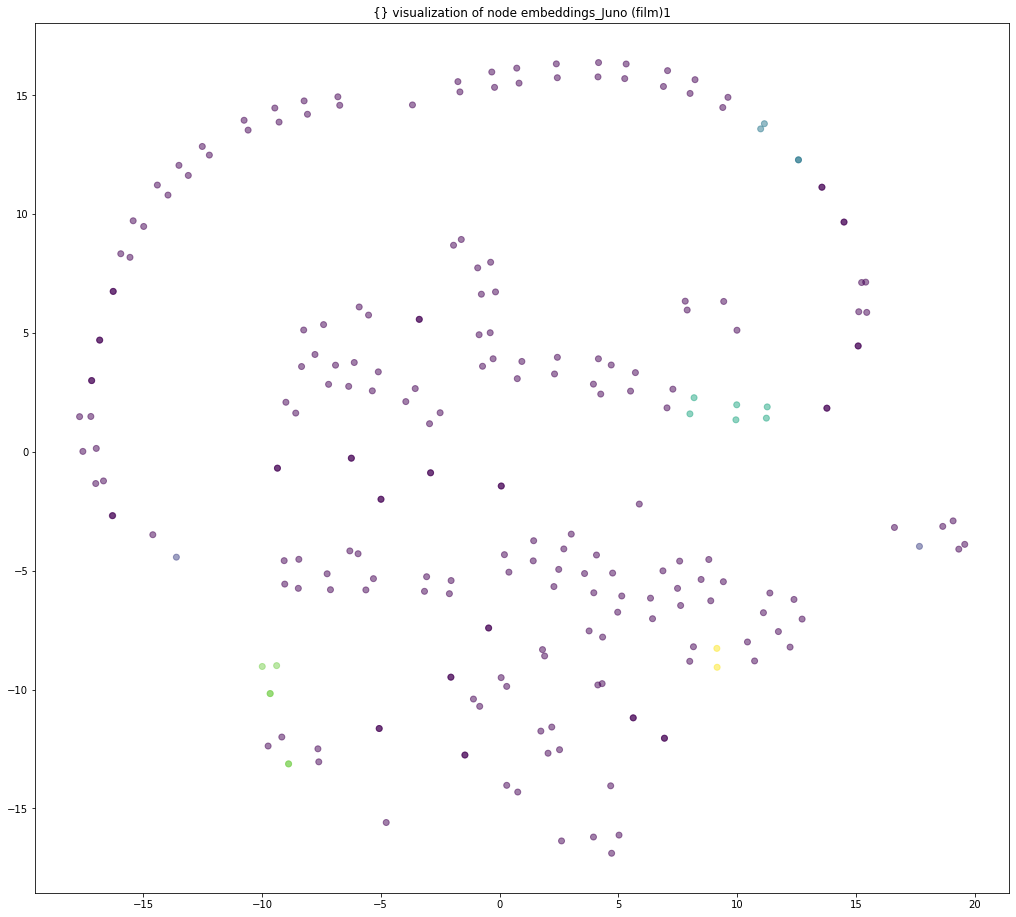

In [76]:
node_embeddings = []
node_colours = []
for i,(name, values) in enumerate(movie_emb.items()):
    for emb in values[0]:
        node_embeddings.append(emb)
    for col in values[1]:
        node_colours.append(col)
node_embeddings_2d = trans.fit_transform(node_embeddings)

plt.figure(figsize=(20, 16))
plt.axes().set(aspect="equal")
X = node_embeddings_2d[:, 0]
Y = node_embeddings_2d[:, 1]
plt.scatter(X, Y, c=node_colours, alpha=0.5)
plt.title("{} visualization of node embeddings_"+name.format(transform.__name__))
#for i, label in enumerate(node_ids):
#    plt.annotate(label, (X[i], Y[i]))

plt.savefig(name+'.png',dpi=300)  
plt.show()

In [68]:
w2v = Word2Vec(vector_size=16, window=5, min_count=0, sg=1, workers=4, epochs=0)
w2v.build_vocab(corpus_iterable=[list(g.nodes())])

In [69]:
w2v.wv['scene_2']

array([ 0.00086999,  0.00947289, -0.00255306, -0.0537291 ,  0.05512653,
        0.04356156, -0.05974638, -0.04439332,  0.01342621,  0.00119314,
       -0.01778831,  0.05443875, -0.05477656, -0.01781817,  0.04552399,
       -0.00529392], dtype=float32)

Juno (film)
Number of random walks: 4178


/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


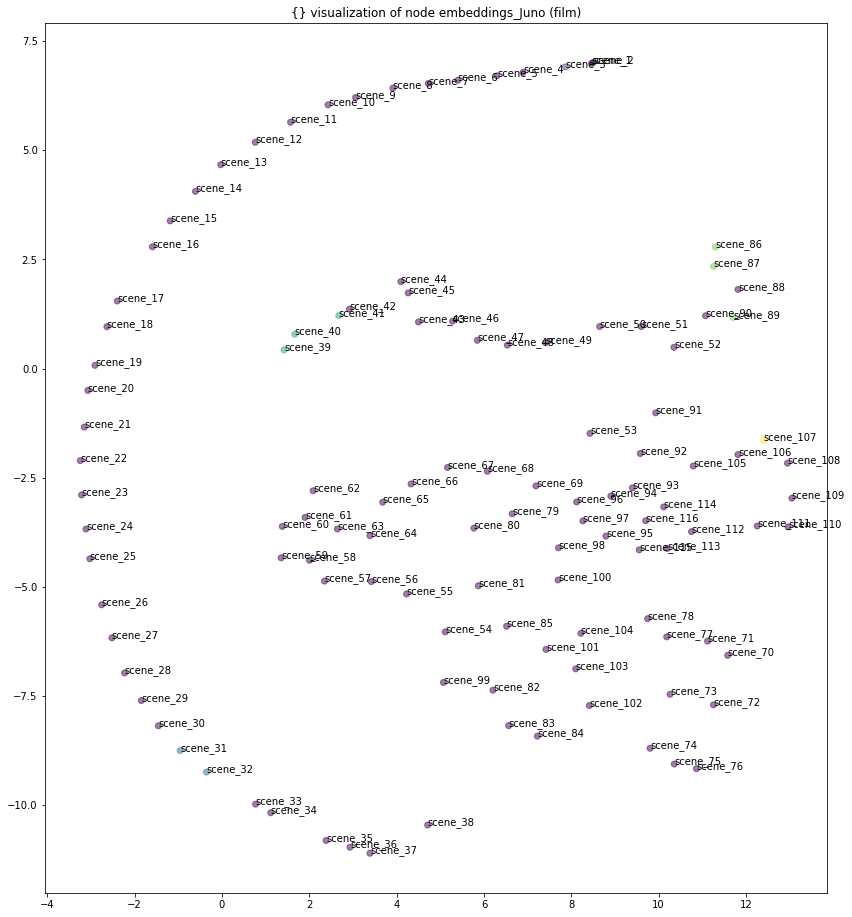

Juno (film)
Number of random walks: 4178


/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


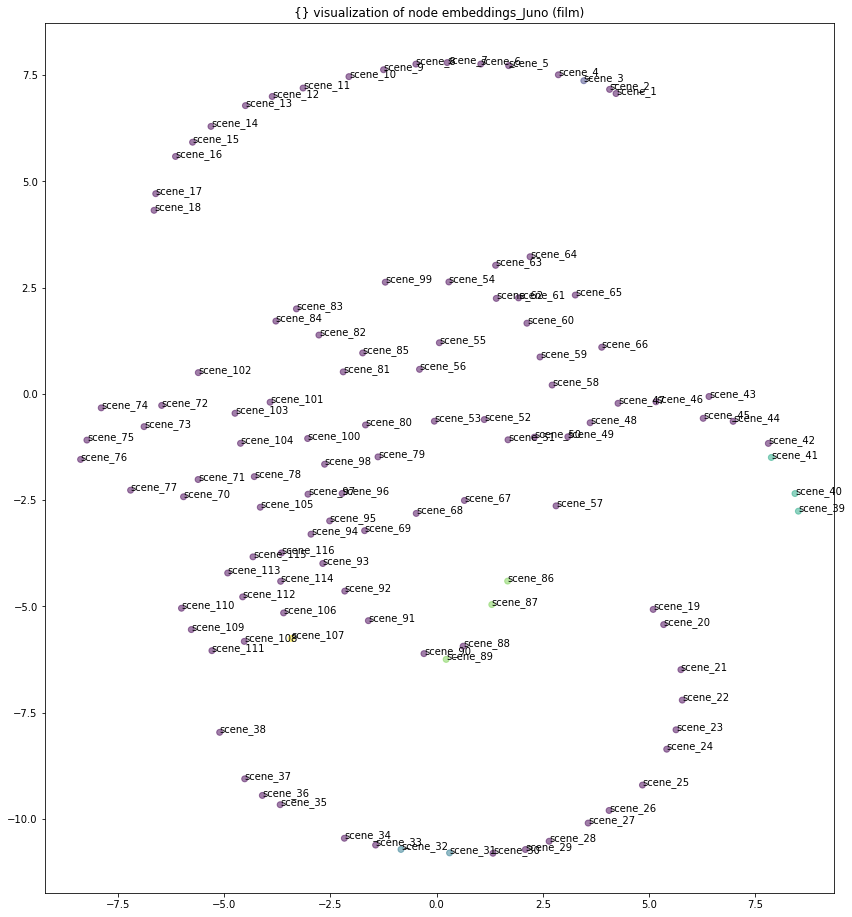

In [75]:
movie_emb = {}
for num, name in enumerate(['Juno (film)','Juno (film)']):
    if name =='Slumdog Millionaire':
        continue
    if num ==5:
        break

    print(name)
    tps = {}
    for i in range(1,6): 
        tp = [tp.replace('[','').replace(']','').split(', ') for tp in tripod[tripod['movie_name']==name]['tp'+str(i)].values]
        tp = list(map(int, tp[0]))
        tps['tp'+str(i)] = tp
    mov = Movie('Segmented_screenplays/'+name+'_script_segmented.txt')
    scene_embedding = {}
    total_embedding = []
    total_sentence = []
    
    for i, char_dict in mov.scene_dict.items():
        scene = {}
        for char, sent in char_dict.items():
            emb = make_embedding(sent)
            scene[char] = emb        
            total_embedding += emb
            total_sentence +=sent
        scene_embedding[i] = scene
    kernel, bias = compute_kernel_bias([total_embedding])
    scene_embedding_reduction = {}
    total_red_embedding = []
    for i, char_dict in scene_embedding.items():
        scene = {}
        for char, emb in char_dict.items():
            re_emb = Dim_reduction(emb, kernel, bias)
            scene[char] = re_emb
            for r_e in re_emb:
                total_red_embedding.append(r_e)
                
        scene_embedding_reduction[i] = scene
    g_list = []
    id_num = 1
    node_embedding = {}
    total_act = []
    for i, (scene, contents) in enumerate(scene_embedding_reduction.items()):
        line = 'scene_' + str(scene) + '  ' + 'scene_' + str(scene+1) + '  ' + '1' + '  ' + str(id_num)
        if i != len(scene_embedding_reduction.items())-1:
            g_list.append([line])
        id_num +=1 
        sent_num = 1
        for char, embs in contents.items():        
            for emb in embs:
                line = 'scene_' + str(scene) + '  ' + str(scene) + '_act_' + str(sent_num) + '  ' + '2' + '  ' + str(id_num)
                total_act.append(str(scene) + '_act_' + str(sent_num))
                node_embedding[str(scene) + '_act_' + str(sent_num)] = emb
                id_num += 1
                g_list.append([line])
                line = str(scene) + '_act_' + str(sent_num) + '  ' + char + '  ' + '3' + '  ' + str(id_num)
                id_num += 1
                sent_num += 1
                g_list.append([line])
        if sent_num!=1:     
            for j in range(sent_num):
                for k in range(j+1,sent_num):
                    line = str(scene) + '_act_' + str(j) + '  ' + str(scene) + '_act_' + str(k) + '  ' + '4' + '  ' + str(id_num)
                    id_num += 1
                    g_list.append([line])    
    with open('test.csv', 'w',newline='') as f: 
        write = csv.writer(f)    
        write.writerows(g_list)
    g= read_graph('test.csv')
    attr = {}
    for node in g.nodes():
        if 'scene' in node:
            attr[node]='scene'
        elif 'act' in node:
            attr[node]='act'
        elif 'char' in node:
            attr[node]='char'
    nx.set_node_attributes(g, attr,"label")
    stellar_g = StellarGraph.from_networkx(g)
    stellar_g.info()
    
       # Create the random walker
    rw = UniformRandomMetaPathWalk(stellar_g)

    walks = rw.run(
        nodes=list(stellar_g.nodes()),  # root nodes
        length=walk_length,  # maximum length of a random walk
        n=1,  # number of random walks per root node
        metapaths=metapaths,  # the metapaths
    )

    print("Number of random walks: {}".format(len(walks))) 
    
    w2v = Word2Vec(vector_size=10, window=5, min_count=0, sg=1, workers=4, epochs=0)
    w2v.build_vocab(corpus_iterable=[list(g.nodes())])
    for key in w2v.wv.index_to_key:
        if key in node_embedding.keys():
            w2v.wv[key] = node_embedding[key]
    
    w2v.train(walks, total_examples=w2v.corpus_count, epochs=60)
    # Retrieve node embeddings and corresponding subjects
    node_ids = [i for i in w2v.wv.index_to_key if 'scene' in i]
    node_ids.sort()
    node_ids.sort(key=len)
    node_embeddings = (
        w2v.wv[node_ids]
    )  # numpy.ndarray of size number of nodes times embeddings dimensionality
    if name in movie_emb.keys():
        movie_emb[name+'1'] = [node_embeddings]
    
        
    movie_emb[name] = [node_embeddings]
    
    node_targets = [stellar_g.node_type(node_id) for node_id in node_ids]
    node_embeddings_2d = trans.fit_transform(node_embeddings)
    label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
    node_colours = [label_map[target] for target in node_targets]
    movie_emb[name] += [node_colours]
    if num==1:
        movie_emb[name+'1'] += [node_colours]
    for i, value in enumerate(tps.values()):
        for val in value:
            node_colours[val-1] = i+1 
    plt.figure(figsize=(20, 16))
    plt.axes().set(aspect="equal")
    X = node_embeddings_2d[:, 0]
    Y = node_embeddings_2d[:, 1]
    plt.scatter(X, Y, c=node_colours, alpha=0.5)
    plt.title("{} visualization of node embeddings_"+name.format(transform.__name__))
    for i, label in enumerate(node_ids):
        plt.annotate(label, (X[i], Y[i]))

    plt.savefig(name+'.png',dpi=300)  
    plt.show()

In [ ]:
[4, 5, 6, 27, 29, 33, 34, 36, 68, 75, 79, 82, 84, 86, 91, 92, 94, 95, 98, 105, 128, 135, 150]

In [ ]:
[41, 114, 118, 119, 121, 122, 126, 146]

In [ ]:
[4, 5, 33, 79, 82, 84, 91, 94, 95, 105, 135]

# char 시각화

## TSNE

In [21]:
import random

In [15]:
walk_length = 5  # maximum length of a random walk to use throughout this notebook

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["act", "scene", "act"],
#    ["act", "act", "scene", "act", "act"],
    ["act",'char', "act"],
#    ["act","act","scene","act"],
#    ["char","act","act","char"],
#    ["act", "act", "char", "act", "act"],
#    ['char','act','scene','act','char'],
    ['scene','act','char','act','scene']
]

metapaths2 = [
    ['char','act','scene','act','char']
]

metapaths3 = [
    ["act","act","scene","act","act"],
    ["char","act","act","char"],
]

In [16]:
movie_emb = {}
for num, name in enumerate(tripod['movie_name']):
#    if 'Soldier' not in name:
#        continue
    if num ==8:
        break
#    name = 'Soldier (1998 American film)'
    print(name)
    tps = {}
#    for i in range(1,6): 
#        tp = [tp.replace('[','').replace(']','').split(', ') for tp in tripod[tripod['movie_name']==name]['tp'+str(i)].values]
#        tp = list(map(int, tp[num]))
#        tps['tp'+str(i)] = tp
    mov = Movie('Segmented_screenplays/'+name+'_script_segmented.txt')
    main_char = mov.find_maincharacter_name(num=8)
    pro = main_char[0]
    pro2 = main_char[1]
    scene_embedding = {}
    total_embedding = []
    total_sentence = []
    pro_scene = []
    pro_scene2 = []
    
    for i, char_dict in mov.scene_dict.items():
        scene = {}
        for char, sent in char_dict.items():
            emb = make_embedding(sent)
            scene[char] = [emb,sent]       
            total_embedding += emb
            total_sentence +=sent
        scene_embedding[i] = scene
    
    emb_act = []
    g_list = []
    id_num = 1
    node_embedding = {}
    total_act = []
    for i, (scene, contents) in enumerate(scene_embedding.items()):
        #line = 'scene_' + str(scene) + '  ' + 'scene_' + str(scene+1) + '  ' + '1' + '  ' + str(id_num)
        #if i != len(scene_embedding_reduction.items())-1:
        #    g_list.append([line])
        #id_num +=1 
        sent_num = 1
        sentnum_emb = {}
        sentnum_sent = {}
        for char, (embs,sent) in contents.items():        
            for emb in embs:
                sentnum_emb[sent_num] = emb
                sentnum_sent[sent_num] = sent
                line = 'scene_' + str(scene) + '  ' + str(scene) + '_act_' + str(sent_num) + '  ' + '2' + '  ' + str(id_num)
                total_act.append(str(scene) + '_act_' + str(sent_num))
                node_embedding[str(scene) + '_act_' + str(sent_num)] = emb
                id_num += 1
                g_list.append([line])
                line = str(scene) + '_act_' + str(sent_num) + '  ' + 'char_' + char + '  ' + '3' + '  ' + str(id_num)
                id_num += 1
                sent_num += 1
                g_list.append([line])
        if sent_num!=1:     
            for j in range(1,sent_num):
                for k in range(j+1,sent_num):
                    if len(sentnum_sent[j])>25 and len(sentnum_sent[k])>25:
                        score = util.cos_sim(sentnum_emb[j],sentnum_emb[k])[0]
                        if score > 0.66 and score< 0.99:
                            line = str(scene) + '_act_' + str(j) + '  ' + str(scene) + '_act_' + str(k) + '  ' + '4' + '  ' + str(id_num)
                            id_num += 1
                            g_list.append([line])
        
            
    with open('test.csv', 'w',newline='') as f: 
        write = csv.writer(f)    
        write.writerows(g_list)
    g= read_graph('test.csv')
    attr = {}
    for node in g.nodes():
        if 'scene' in node:
            attr[node]='scene'
        elif 'act' in node:
            attr[node]='act'
        elif 'char' in node:
            attr[node]='char'
    nx.set_node_attributes(g, attr,"label")
    stellar_g = StellarGraph.from_networkx(g)
    stellar_g.info()
    
       # Create the random walker
    rw = UniformRandomMetaPathWalk(stellar_g)
    
    walks1 = rw.run(
            nodes=list(stellar_g.nodes()),  # root nodes
            length=walk_length,  # maximum length of a random walk
            n=1,  # number of random walks per root node
            metapaths=metapaths,  # the metapaths
        )

    walks2 = rw.run(
            nodes=list(stellar_g.nodes()),  # root nodes
            length=walk_length*2,  # maximum length of a random walk
            n=30,  # number of random walks per root node
            metapaths=metapaths2,  # the metapaths
        )

    walks3 = rw.run(
            nodes=list(stellar_g.nodes()),  # root nodes
            length=walk_length,  # maximum length of a random walk
            n=1,  # number of random walks per root node
            metapaths=metapaths3,  # the metapaths
        )


    walks = []
    for w in walks1:
        walks.append(w)
    for w in walks2:
        walks.append(w)
    for w in walks3:
        walks.append(w)

    print("Number of random walks: {}".format(len(walks))) 
    
    w2v = Word2Vec(vector_size=384, window=5, min_count=0, sg=1, workers=4, epochs=0)
    w2v.build_vocab(corpus_iterable=[list(g.nodes())])
    for key in w2v.wv.index_to_key:
        if key in node_embedding.keys():
            w2v.wv[key] = node_embedding[key]
            
    random.shuffle(walks)
    
    w2v.train(walks, total_examples=w2v.corpus_count, epochs=60)
    # Retrieve node embeddings and corresponding subjects
    char_ids = [i for i in w2v.wv.index_to_key if 'scene' not in i and 'act' not in i]
    node_ids = [i for i in w2v.wv.index_to_key if 'scene' in i]
    node_ids.sort()
    node_ids.sort(key=len)
#    print(node_ids)
    node_embeddings = (
        w2v.wv[node_ids]
    )  # numpy.ndarray of size number of nodes times embeddings dimensionality
#    print(char_ids)
    char_embeddings = (
        w2v.wv[char_ids]
    )
    
    
    movie_emb[name] = [node_embeddings]
#    movie_emb[name].append()
    total_emb = []
    
    node_targets = [stellar_g.node_type(node_id) for node_id in node_ids]
#    node_targets2 = [stellar_g.node_type(node_id) for node_id in char_ids]
    node_embeddings_2d = trans.fit_transform(node_embeddings)
    #label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
    node_colours = [0 for i in node_targets]
    print(pro_scene)
    print(node_ids)
    for i in pro_scene:
        for num, node_id in enumerate(node_ids):
            if int(node_id[6:]) == i:
                node_colours[num] = 1
#    for i in pro_scene2:
#        for num, node_id in enumerate(node_ids):
#            if int(node_id[6:]) == i:
#                node_colours[num] = 3
#    for i in set(pro_scene)&set(pro_scene2):
#        for num, node_id in enumerate(node_ids):
#            if int(node_id[6:]) == i:
#                node_colours[num] = 2
    
    movie_emb[name] += [node_colours]
    color = 0
    last = 0

    plt.figure(figsize=(5, 4))
    plt.axes().set(aspect="equal")
    X = node_embeddings_2d[:, 0]
    Y = node_embeddings_2d[:, 1]
    scatter = plt.scatter(X, Y, c=node_colours, alpha=0.5)
    plt.title("{} visualization of node embeddings_"+name.format(transform.__name__))
    plt.legend(*scatter.legend_elements(), loc="upper right",bbox_to_anchor=(1.2, 1))
 #   for i, label in enumerate(node_ids):
 #       plt.annotate(label, (X[i], Y[i]))

#    plt.savefig(name+'.png',dpi=300)  
    plt.show()

The Back-up Plan
Number of random walks: 5957


NameError: name 'trans' is not defined

## PCA

In [16]:
transform = PCA  # PCA

trans = transform(n_components=2)

The Back-up Plan
Number of random walks: 5957
[]
['scene_1', 'scene_2', 'scene_3', 'scene_4', 'scene_5', 'scene_6', 'scene_7', 'scene_8', 'scene_9', 'scene_10', 'scene_11', 'scene_12', 'scene_13', 'scene_14', 'scene_15', 'scene_16', 'scene_18', 'scene_19', 'scene_20', 'scene_21', 'scene_22', 'scene_23', 'scene_24', 'scene_25', 'scene_26', 'scene_27', 'scene_28', 'scene_29', 'scene_30', 'scene_31', 'scene_32', 'scene_33', 'scene_34', 'scene_35', 'scene_36', 'scene_37', 'scene_38', 'scene_39', 'scene_40', 'scene_41', 'scene_42', 'scene_43', 'scene_45', 'scene_46', 'scene_47', 'scene_48', 'scene_49', 'scene_50', 'scene_52', 'scene_53', 'scene_54', 'scene_55', 'scene_56', 'scene_57', 'scene_58', 'scene_59', 'scene_60', 'scene_61', 'scene_62', 'scene_63', 'scene_64', 'scene_65', 'scene_66', 'scene_67', 'scene_68', 'scene_69', 'scene_71', 'scene_72', 'scene_73', 'scene_74', 'scene_75', 'scene_76', 'scene_77', 'scene_78', 'scene_79', 'scene_80', 'scene_81', 'scene_82', 'scene_83', 'scene_84',

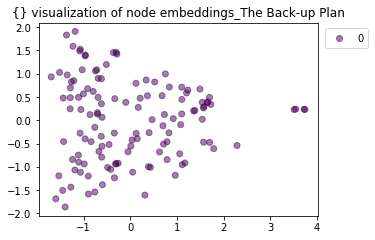

The Shining (film)


KeyboardInterrupt: 

In [32]:
movie_emb = {}
for num, name in enumerate(tripod['movie_name']):
#    if 'Soldier' not in name:
#        continue
    if num ==8:
        break
#    name = 'Soldier (1998 American film)'
    print(name)
    tps = {}
#    for i in range(1,6): 
#        tp = [tp.replace('[','').replace(']','').split(', ') for tp in tripod[tripod['movie_name']==name]['tp'+str(i)].values]
#        tp = list(map(int, tp[num]))
#        tps['tp'+str(i)] = tp
    mov = Movie('Segmented_screenplays/'+name+'_script_segmented.txt')
    main_char = mov.find_maincharacter_name(num=8)
    pro = main_char[0]
    pro2 = main_char[1]
    scene_embedding = {}
    total_embedding = []
    total_sentence = []
    pro_scene = []
    pro_scene2 = []
    
    
    
    for i, char_dict in mov.scene_dict.items():
        scene = {}
        for char, sent in char_dict.items():
            emb = make_embedding(sent)
            scene[char] = [emb,sent]       
            total_embedding += emb
            total_sentence +=sent
        scene_embedding[i] = scene
    
    emb_act = []
    g_list = []
    id_num = 1
    node_embedding = {}
    total_act = []
    for i, (scene, contents) in enumerate(scene_embedding.items()):
        #line = 'scene_' + str(scene) + '  ' + 'scene_' + str(scene+1) + '  ' + '1' + '  ' + str(id_num)
        #if i != len(scene_embedding_reduction.items())-1:
        #    g_list.append([line])
        #id_num +=1 
        sent_num = 1
        sentnum_emb = {}
        sentnum_sent = {}
        for char, (embs,sent) in contents.items():        
            for emb in embs:
                sentnum_emb[sent_num] = emb
                sentnum_sent[sent_num] = sent
                line = 'scene_' + str(scene) + '  ' + str(scene) + '_act_' + str(sent_num) + '  ' + '2' + '  ' + str(id_num)
                total_act.append(str(scene) + '_act_' + str(sent_num))
                node_embedding[str(scene) + '_act_' + str(sent_num)] = emb
                id_num += 1
                g_list.append([line])
                line = str(scene) + '_act_' + str(sent_num) + '  ' + 'char_' + char + '  ' + '3' + '  ' + str(id_num)
                id_num += 1
                sent_num += 1
                g_list.append([line])
        if sent_num!=1:     
            for j in range(1,sent_num):
                for k in range(j+1,sent_num):
                    if len(sentnum_sent[j])>25 and len(sentnum_sent[k])>25:
                        score = util.cos_sim(sentnum_emb[j],sentnum_emb[k])[0]
                        if score > 0.66 and score< 0.99:
                            line = str(scene) + '_act_' + str(j) + '  ' + str(scene) + '_act_' + str(k) + '  ' + '4' + '  ' + str(id_num)
                            id_num += 1
                            g_list.append([line])
        
            
    with open('test.csv', 'w',newline='') as f: 
        write = csv.writer(f)    
        write.writerows(g_list)
    g= read_graph('test.csv')
    attr = {}
    for node in g.nodes():
        if 'scene' in node:
            attr[node]='scene'
        elif 'act' in node:
            attr[node]='act'
        elif 'char' in node:
            attr[node]='char'
    nx.set_node_attributes(g, attr,"label")
    stellar_g = StellarGraph.from_networkx(g)
    stellar_g.info()
    
       # Create the random walker
    rw = UniformRandomMetaPathWalk(stellar_g)
    
    walks1 = rw.run(
            nodes=list(stellar_g.nodes()),  # root nodes
            length=walk_length,  # maximum length of a random walk
            n=1,  # number of random walks per root node
            metapaths=metapaths,  # the metapaths
        )

    walks2 = rw.run(
            nodes=list(stellar_g.nodes()),  # root nodes
            length=walk_length*2,  # maximum length of a random walk
            n=30,  # number of random walks per root node
            metapaths=metapaths2,  # the metapaths
        )

    walks3 = rw.run(
            nodes=list(stellar_g.nodes()),  # root nodes
            length=walk_length,  # maximum length of a random walk
            n=1,  # number of random walks per root node
            metapaths=metapaths3,  # the metapaths
        )


    walks = []
    for w in walks1:
        walks.append(w)
    for w in walks2:
        walks.append(w)
    for w in walks3:
        walks.append(w)

    print("Number of random walks: {}".format(len(walks))) 
    
    w2v = Word2Vec(vector_size=384, window=5, min_count=0, sg=1, workers=4, epochs=0)
    w2v.build_vocab(corpus_iterable=[list(g.nodes())])
    for key in w2v.wv.index_to_key:
        if key in node_embedding.keys():
            w2v.wv[key] = node_embedding[key]
            
    random.shuffle(walks)
    
    w2v.train(walks, total_examples=w2v.corpus_count, epochs=60)
    # Retrieve node embeddings and corresponding subjects
    char_ids = [i for i in w2v.wv.index_to_key if 'scene' not in i and 'act' not in i]
    node_ids = [i for i in w2v.wv.index_to_key if 'scene' in i]
    node_ids.sort()
    node_ids.sort(key=len)
#    print(node_ids)
    node_embeddings = (
        w2v.wv[node_ids]
    )  # numpy.ndarray of size number of nodes times embeddings dimensionality
#    print(char_ids)
    char_embeddings = (
        w2v.wv[char_ids]
    )
    
    
    movie_emb[name] = [node_embeddings]
#    movie_emb[name].append()
    total_emb = []
    
    node_targets = [stellar_g.node_type(node_id) for node_id in node_ids]
#    node_targets2 = [stellar_g.node_type(node_id) for node_id in char_ids]
    node_embeddings_2d = trans.fit_transform(node_embeddings)
    #label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
    node_colours = [0 for i in node_targets]
    print(pro_scene)
    print(node_ids)
    for i in pro_scene:
        for num, node_id in enumerate(node_ids):
            if int(node_id[6:]) == i:
                node_colours[num] = 1
#    for i in pro_scene2:
#        for num, node_id in enumerate(node_ids):
#            if int(node_id[6:]) == i:
#                node_colours[num] = 3
#    for i in set(pro_scene)&set(pro_scene2):
#        for num, node_id in enumerate(node_ids):
#            if int(node_id[6:]) == i:
#                node_colours[num] = 2
    
    movie_emb[name] += [node_colours]
    color = 0
    last = 0

    plt.figure(figsize=(5, 4))
    plt.axes().set(aspect="equal")
    X = node_embeddings_2d[:, 0]
    Y = node_embeddings_2d[:, 1]
    scatter = plt.scatter(X, Y, c=node_colours, alpha=0.5)
    plt.title("{} visualization of node embeddings_"+name.format(transform.__name__))
    plt.legend(*scatter.legend_elements(), loc="upper right",bbox_to_anchor=(1.2, 1))
 #   for i, label in enumerate(node_ids):
 #       plt.annotate(label, (X[i], Y[i]))

#    plt.savefig(name+'.png',dpi=300)  
    plt.show()

The Back-up Plan
Number of random walks: 8447
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 72, 73, 74, 75, 76, 77, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 97, 98, 99, 100, 101, 102, 103, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132]
['scene_1', 'scene_2', 'scene_3', 'scene_4', 'scene_5', 'scene_6', 'scene_7', 'scene_8', 'scene_9', 'scene_10', 'scene_11', 'scene_12', 'scene_13', 'scene_14', 'scene_15', 'scene_16', 'scene_18', 'scene_19', 'scene_20', 'scene_21', 'scene_22', 'scene_23', 'scene_24', 'scene_25', 'scene_26', 'scene_27', 'scene_28', 'scene_29', 'scene_30', 'scene_31', 'scene_32', 'scene_33', 'scene_34', 'scene_35', 'scene_36', 'scene_37', 'scene_38', 'scene_39', 'sc

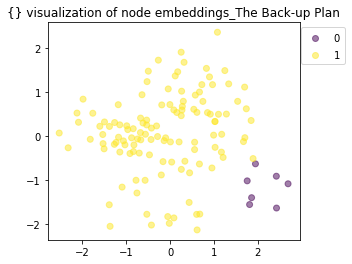

The Shining (film)
Number of random walks: 8826
[4, 7, 10, 12, 22, 25, 26, 29, 31, 32, 37, 44, 45, 48, 53, 57, 72, 76, 77, 78, 79, 80, 81, 82, 88, 95, 97, 100, 101, 107, 108, 109, 110, 113, 119, 140, 141, 142, 144, 145, 147, 148, 149, 151, 152, 153, 155, 156, 157, 162, 167, 169, 172, 176, 178, 179, 184, 187, 189, 191, 192, 193, 194, 199, 205, 211, 212, 213, 215, 217, 219, 223, 225, 228, 229, 230]
['scene_1', 'scene_3', 'scene_4', 'scene_6', 'scene_7', 'scene_8', 'scene_10', 'scene_12', 'scene_13', 'scene_15', 'scene_17', 'scene_18', 'scene_19', 'scene_20', 'scene_22', 'scene_25', 'scene_26', 'scene_27', 'scene_28', 'scene_29', 'scene_30', 'scene_31', 'scene_32', 'scene_33', 'scene_34', 'scene_35', 'scene_36', 'scene_37', 'scene_38', 'scene_39', 'scene_41', 'scene_42', 'scene_44', 'scene_45', 'scene_46', 'scene_47', 'scene_48', 'scene_49', 'scene_51', 'scene_52', 'scene_53', 'scene_54', 'scene_55', 'scene_57', 'scene_58', 'scene_59', 'scene_60', 'scene_61', 'scene_63', 'scene_65', 'scen

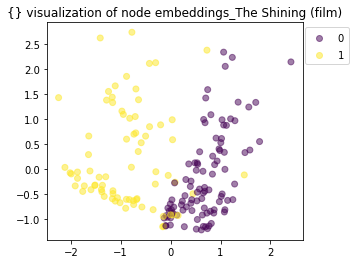

Juno (film)
Number of random walks: 6571
[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 75, 76, 79, 81, 82, 83, 84, 87, 88, 89, 90, 92, 94, 97, 98, 99, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116]
['scene_1', 'scene_2', 'scene_3', 'scene_4', 'scene_5', 'scene_6', 'scene_7', 'scene_8', 'scene_9', 'scene_10', 'scene_11', 'scene_12', 'scene_13', 'scene_14', 'scene_16', 'scene_17', 'scene_18', 'scene_19', 'scene_20', 'scene_21', 'scene_22', 'scene_23', 'scene_25', 'scene_26', 'scene_27', 'scene_28', 'scene_29', 'scene_30', 'scene_31', 'scene_32', 'scene_33', 'scene_34', 'scene_35', 'scene_37', 'scene_38', 'scene_40', 'scene_41', 'scene_42', 'scene_43', 'scene_44', 'scene_45', 'scene_46', 'scene_47', 'scene_48', 'scene_49', 'scene_50', 'scene_51', 'scene_52', 'scene_54', 'scene_55', 'sce

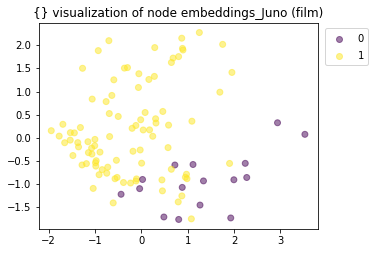

Soldier (1998 American film)
Number of random walks: 9883
[5, 10, 11, 12, 13, 17, 18, 19, 20, 25, 26, 27, 33, 35, 36, 40, 45, 46, 48, 49, 50, 51, 52, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 73, 74, 77, 78, 81, 82, 86, 87, 88, 89, 98, 106, 108, 111, 114, 115, 116, 118, 130, 136, 137, 138, 142, 146, 152, 155, 157, 159, 161, 162, 163, 164, 166, 170, 171, 173, 175, 176, 178, 183, 185, 191, 193, 195, 196, 201, 203, 208, 210, 212, 213, 219, 225, 229]
['scene_1', 'scene_2', 'scene_3', 'scene_5', 'scene_6', 'scene_7', 'scene_9', 'scene_10', 'scene_11', 'scene_12', 'scene_13', 'scene_16', 'scene_17', 'scene_18', 'scene_19', 'scene_20', 'scene_23', 'scene_24', 'scene_25', 'scene_26', 'scene_27', 'scene_28', 'scene_30', 'scene_32', 'scene_33', 'scene_34', 'scene_35', 'scene_36', 'scene_37', 'scene_40', 'scene_42', 'scene_44', 'scene_45', 'scene_46', 'scene_48', 'scene_49', 'scene_50', 'scene_51', 'scene_52', 'scene_53', 'scene_54', 'scene_55', 'scene_56', 'scene_57', 'scene_58

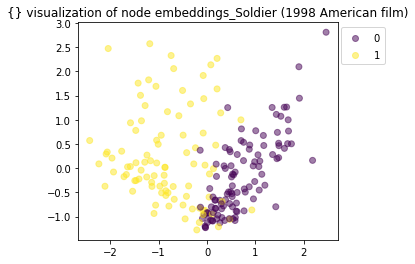

Panic Room
Number of random walks: 5983
[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 18, 23, 26, 28, 30, 31, 33, 34, 35, 38, 40, 41, 42, 43, 44, 46, 47, 48, 50, 51, 53, 57, 58, 61, 62, 63, 64, 65, 66, 69, 72, 73, 75, 77, 79, 81, 83, 84, 86, 88, 90, 92, 93, 96, 98, 100, 102, 104, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 128, 133, 135, 136, 138, 140, 141, 142, 146, 147, 148, 150, 152, 153, 154, 156, 157, 158, 159, 160, 161, 162, 164, 166, 167]
['scene_4', 'scene_5', 'scene_6', 'scene_7', 'scene_8', 'scene_9', 'scene_10', 'scene_11', 'scene_12', 'scene_13', 'scene_14', 'scene_15', 'scene_16', 'scene_17', 'scene_18', 'scene_23', 'scene_25', 'scene_26', 'scene_27', 'scene_28', 'scene_30', 'scene_31', 'scene_33', 'scene_34', 'scene_35', 'scene_37', 'scene_38', 'scene_39', 'scene_40', 'scene_41', 'scene_42', 'scene_43', 'scene_44', 'scene_46', 'scene_47', 'scene_48', 'scene_49', 'scene_50', 'scene_51', 'scene_52', 'scene_53', 'scene_54', 'scene_56', 'scene_57', 'scene_58', 'scene_60', 

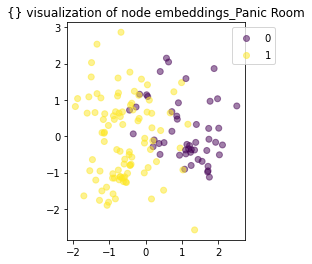

Arbitrage (film)
Number of random walks: 8013
[1, 2, 3, 5, 7, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 29, 33, 34, 36, 37, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 55, 57, 59, 65, 70, 73, 75, 78, 79, 80, 82, 83, 84, 85, 88, 91, 93, 94, 95, 96, 97, 99, 103, 106, 107]
['scene_1', 'scene_2', 'scene_3', 'scene_4', 'scene_5', 'scene_7', 'scene_8', 'scene_9', 'scene_10', 'scene_11', 'scene_12', 'scene_13', 'scene_14', 'scene_15', 'scene_16', 'scene_17', 'scene_18', 'scene_19', 'scene_20', 'scene_21', 'scene_22', 'scene_23', 'scene_24', 'scene_25', 'scene_27', 'scene_28', 'scene_29', 'scene_30', 'scene_33', 'scene_34', 'scene_35', 'scene_36', 'scene_37', 'scene_39', 'scene_40', 'scene_41', 'scene_42', 'scene_43', 'scene_44', 'scene_45', 'scene_46', 'scene_47', 'scene_48', 'scene_49', 'scene_50', 'scene_51', 'scene_52', 'scene_53', 'scene_55', 'scene_56', 'scene_57', 'scene_58', 'scene_59', 'scene_60', 'scene_61', 'scene_62', 'scene_64', 'scene_65', 'scene_

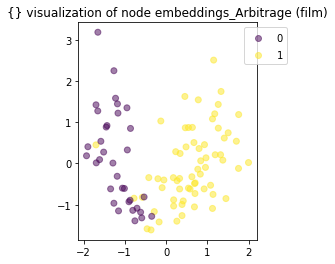

The Breakfast Club
Number of random walks: 4682
[1, 3, 6, 8, 10, 12, 14, 18, 19, 21, 26, 28, 30, 32, 33, 35, 37, 39, 40, 41, 42]
['scene_1', 'scene_2', 'scene_3', 'scene_4', 'scene_5', 'scene_6', 'scene_7', 'scene_8', 'scene_9', 'scene_10', 'scene_11', 'scene_12', 'scene_13', 'scene_14', 'scene_16', 'scene_17', 'scene_18', 'scene_19', 'scene_20', 'scene_21', 'scene_22', 'scene_23', 'scene_25', 'scene_26', 'scene_27', 'scene_28', 'scene_29', 'scene_30', 'scene_31', 'scene_32', 'scene_33', 'scene_35', 'scene_36', 'scene_37', 'scene_38', 'scene_39', 'scene_40', 'scene_41', 'scene_42']


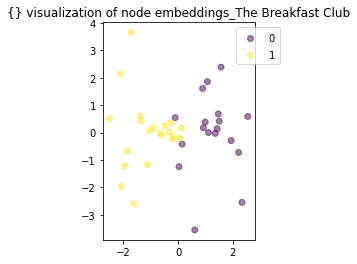

Slumdog Millionaire
Number of random walks: 9960
[2, 4, 5, 8, 9, 11, 12, 13, 16, 19, 20, 22, 23, 24, 25, 26, 29, 30, 31, 32, 34, 35, 36, 38, 40, 41, 43, 44, 45, 46, 47, 49, 51, 52, 53, 56, 57, 58, 59, 60, 62, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 103, 104, 106, 107, 108, 109, 110, 111, 116, 117, 119, 120, 121, 122, 124, 125, 126, 128, 130, 131, 132, 133, 134, 135, 136, 138, 139, 140, 141, 142, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 157, 159, 161, 162, 165, 166, 173, 177, 179, 182, 189, 191, 192, 193, 194]
['scene_1', 'scene_2', 'scene_4', 'scene_5', 'scene_6', 'scene_7', 'scene_8', 'scene_9', 'scene_10', 'scene_11', 'scene_12', 'scene_13', 'scene_14', 'scene_15', 'scene_16', 'scene_18', 'scene_19', 'scene_20', 'scene_21', 'scene_22', 'scene_23', 'scene_24', 'scene_25', 'scene_26', 'scene_27', 'scene_28', 'scene_29', 'scene_30', 'scene_31', 'scene_32', 'scene_33', 'scene_34', 'scene

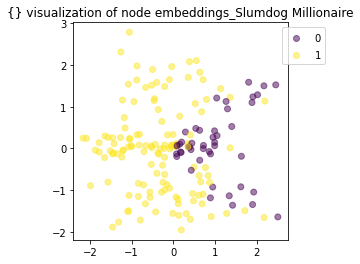

In [60]:
movie_emb = {}
for num, name in enumerate(tripod['movie_name']):
#    if 'Soldier' not in name:
#        continue
    if num ==8:
        break
#    name = 'Soldier (1998 American film)'
    print(name)
    tps = {}
#    for i in range(1,6): 
#        tp = [tp.replace('[','').replace(']','').split(', ') for tp in tripod[tripod['movie_name']==name]['tp'+str(i)].values]
#        tp = list(map(int, tp[num]))
#        tps['tp'+str(i)] = tp
    mov = Movie('../data/scriptbase/'+name+'_script_segmented.txt')
    main_char = mov.find_maincharacter_name(num=8)
    pro = main_char[0]
    pro2 = main_char[1]
    scene_embedding = {}
    total_embedding = []
    total_sentence = []
    pro_scene = []
    pro_scene2 = []
    
    
    
    for i, char_dict in mov.scene_dict.items():
        scene = {}
        if pro in char_dict.keys():
            pro_scene.append(i)
        for char, sent in char_dict.items():
            emb = make_embedding(sent)
            scene[char] = [emb,sent]       
            total_embedding += emb
            total_sentence +=sent
        scene_embedding[i] = scene

        
    emb_act = []
    g_list = []
    id_num = 1
    node_embedding = {}
    total_act = []
    for i, (scene, contents) in enumerate(scene_embedding.items()):
        #line = 'scene_' + str(scene) + '  ' + 'scene_' + str(scene+1) + '  ' + '1' + '  ' + str(id_num)
        #if i != len(scene_embedding_reduction.items())-1:
        #    g_list.append([line])
        #id_num +=1 
        sent_num = 1
        sentnum_emb = {}
        sentnum_sent = {}
        total_sent = 0
        for char, (embs,sent) in contents.items():
            total_sent += len(embs)
        for char, (embs,sent) in contents.items():   
            char_len = len(embs)
            for emb,s in zip(embs,sent):
                sentnum_emb[sent_num] = emb
                sentnum_sent[sent_num] = s
                line = 'scene_' + str(scene) + '  ' + str(scene) + '_act_' + str(sent_num) + '  ' + '2' + '  ' + str(id_num)
                total_act.append(str(scene) + '_act_' + str(sent_num))
                node_embedding[str(scene) + '_act_' + str(sent_num)] = np.concatenate((emb,np.zeros([16])))
                id_num += 1
                g_list.append([line])
                line = str(scene) + '_act_' + str(sent_num) + '  ' + 'char_' + char + '  ' + '3' + '  ' + str(id_num)
                id_num += 1
                sent_num += 1
                g_list.append([line])
       
        if sent_num!=1:     
            for j in range(1,sent_num):
                for k in range(j+1,sent_num):
                    if len(sentnum_sent[j])>25 and len(sentnum_sent[k])>25:
                        score = util.cos_sim(sentnum_emb[j],sentnum_emb[k])[0]
                        if score > 0.6 and score< 0.99:
                            #print(name, sentnum_sent[j])
                            node_embedding[str(scene) + '_act_' + str(j)] = np.concatenate((sentnum_emb[j][:384],positional[scene]))
                            node_embedding[str(scene) + '_act_' + str(k)] = np.concatenate((sentnum_emb[k][:384],positional[scene]))
                            line = str(scene) + '_act_' + str(j) + '  ' + str(scene) + '_act_' + str(k) + '  ' + '4' + '  ' + str(id_num)
                            id_num += 1
                            g_list.append([line])

            
            
    with open('test.csv', 'w',newline='') as f: 
        write = csv.writer(f)    
        write.writerows(g_list)
    g= read_graph('test.csv')
    attr = {}
    for node in g.nodes():
        if 'scene' in node:
            attr[node]='scene'
        elif 'act' in node:
            attr[node]='act'
        elif 'char' in node:
            attr[node]='char'
    nx.set_node_attributes(g, attr,"label")
    stellar_g = StellarGraph.from_networkx(g)
    stellar_g.info()
    
       # Create the random walker
    rw = UniformRandomMetaPathWalk(stellar_g)

    walks1 = rw.run(
        nodes=list(stellar_g.nodes()),  # root nodes
        length=walk_length,  # maximum length of a random walk
        n=2,  # number of random walks per root node
        metapaths=metapaths,  # the metapaths
    )
    walks2 = rw.run(
        nodes=list(stellar_g.nodes()),  # root nodes
        length=walk_length*2,  # maximum length of a random walk
        n=30,  # number of random walks per root node
        metapaths=metapaths2,  # the metapaths
    )
    walks3 = rw.run(
        nodes=list(stellar_g.nodes()),  # root nodes
        length=walk_length,  # maximum length of a random walk
        n=5,  # number of random walks per root node
        metapaths=metapaths3,  # the metapaths
    )
    walks = []
    for w in walks1:
        walks.append(w)
    for w in walks2:
        walks.append(w)
    for w in walks3:
        walks.append(w)
    print("Number of random walks: {}".format(len(walks))) 
    
    w2v = Word2Vec(vector_size=400, window=3, min_count=0, sg=1, workers=4, epochs=0)
    w2v.build_vocab(corpus_iterable=[list(g.nodes())])
#    for key in w2v.wv.index_to_key:
#        if key in node_embedding.keys():
#            w2v.wv[key] = node_embedding[key]
            
    random.shuffle(walks)
    
    w2v.train(walks, total_examples=w2v.corpus_count, epochs=60)
    # Retrieve node embeddings and corresponding subjects
    char_ids = [i for i in w2v.wv.index_to_key if 'scene' not in i and 'act' not in i]
    node_ids = [i for i in w2v.wv.index_to_key if 'scene' in i]
    node_ids.sort()
    node_ids.sort(key=len)
#    print(node_ids)
    node_embeddings = (
        w2v.wv[node_ids]
    )  # numpy.ndarray of size number of nodes times embeddings dimensionality
#    print(char_ids)
    char_embeddings = (
        w2v.wv[char_ids]
    )
    
    
    movie_emb[name] = [node_embeddings]
#    movie_emb[name].append()
    total_emb = []
    
    node_targets = [stellar_g.node_type(node_id) for node_id in node_ids]
#    node_targets2 = [stellar_g.node_type(node_id) for node_id in char_ids]
    node_embeddings_2d = trans.fit_transform(node_embeddings)
    #label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
    node_colours = [0 for i in node_targets]
    print(pro_scene)
    print(node_ids)
    for i in pro_scene:
        for num, node_id in enumerate(node_ids):
            if int(node_id[6:]) == i:
                node_colours[num] = 1
#    for i in pro_scene2:
#        for num, node_id in enumerate(node_ids):
#            if int(node_id[6:]) == i:
#                node_colours[num] = 3
#    for i in set(pro_scene)&set(pro_scene2):
#        for num, node_id in enumerate(node_ids):
#            if int(node_id[6:]) == i:
#                node_colours[num] = 2
    
    movie_emb[name] += [node_colours]
    color = 0
    last = 0

    plt.figure(figsize=(5, 4))
    plt.axes().set(aspect="equal")
    X = node_embeddings_2d[:, 0]
    Y = node_embeddings_2d[:, 1]
    scatter = plt.scatter(X, Y, c=node_colours, alpha=0.5)
    plt.title("{} visualization of node embeddings_"+name.format(transform.__name__))
    plt.legend(*scatter.legend_elements(), loc="upper right",bbox_to_anchor=(1.2, 1))
 #   for i, label in enumerate(node_ids):
 #       plt.annotate(label, (X[i], Y[i]))

    plt.savefig(name+'before.png',dpi=300)  
    plt.show()

In [71]:
name = '500 Days of Summer'

Number of random walks: 8008
['TOM', 'SUMMER', 'ALL', 'MCKENZIE', 'SAY', 'PAUL', 'NARRATOR', 'GIRL']


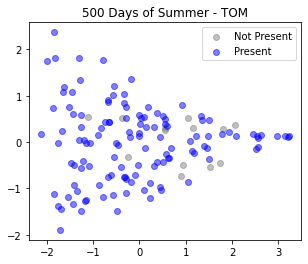

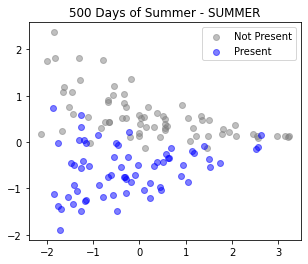

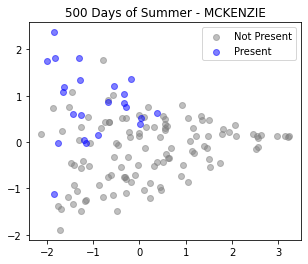

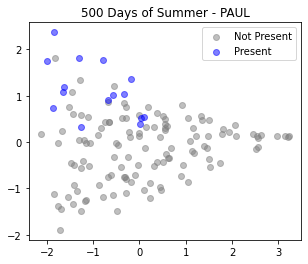

In [74]:
mov = Movie('../data/scriptbase/'+name+'/script.txt')

movie_emb = {}
scene_embedding = {}
total_embedding = []
total_sentence = []
for i, char_dict in mov.scene_dict.items():
    scene = {}
    for char, sent in char_dict.items():
        emb = make_embedding(sent)
        scene[char] = [emb,sent]       
        total_embedding += emb
        total_sentence +=sent
    scene_embedding[i] = scene

    
emb_act = []
g_list = []
id_num = 1
node_embedding = {}
total_act = []
for i, (scene, contents) in enumerate(scene_embedding.items()):
    #line = 'scene_' + str(scene) + '  ' + 'scene_' + str(scene+1) + '  ' + '1' + '  ' + str(id_num)
    #if i != len(scene_embedding_reduction.items())-1:
    #    g_list.append([line])
    #id_num +=1 
    sent_num = 1
    sentnum_emb = {}
    sentnum_sent = {}
    total_sent = 0
    for char, (embs,sent) in contents.items():
        total_sent += len(embs)
    for char, (embs,sent) in contents.items():   
        char_len = len(embs)
        for emb,s in zip(embs,sent):
            sentnum_emb[sent_num] = emb
            sentnum_sent[sent_num] = s
            line = 'scene_' + str(scene) + '  ' + str(scene) + '_act_' + str(sent_num) + '  ' + '2' + '  ' + str(id_num)
            total_act.append(str(scene) + '_act_' + str(sent_num))
            node_embedding[str(scene) + '_act_' + str(sent_num)] = np.concatenate((emb,np.zeros([16])))
            id_num += 1
            g_list.append([line])
            line = str(scene) + '_act_' + str(sent_num) + '  ' + 'char_' + char + '  ' + '3' + '  ' + str(id_num)
            id_num += 1
            sent_num += 1
            g_list.append([line])
   
    if sent_num!=1:     
        for j in range(1,sent_num):
            for k in range(j+1,sent_num):
                if len(sentnum_sent[j])>25 and len(sentnum_sent[k])>25:
                    score = util.cos_sim(sentnum_emb[j],sentnum_emb[k])[0]
                    if score > 0.6 and score< 0.99:
                        #print(name, sentnum_sent[j])
                        node_embedding[str(scene) + '_act_' + str(j)] = np.concatenate((sentnum_emb[j][:384],positional[scene]))
                        node_embedding[str(scene) + '_act_' + str(k)] = np.concatenate((sentnum_emb[k][:384],positional[scene]))
                        line = str(scene) + '_act_' + str(j) + '  ' + str(scene) + '_act_' + str(k) + '  ' + '4' + '  ' + str(id_num)
                        id_num += 1
                        g_list.append([line])

        
        
with open('test.csv', 'w',newline='') as f: 
    write = csv.writer(f)    
    write.writerows(g_list)
g= read_graph('test.csv')
attr = {}
for node in g.nodes():
    if 'scene' in node:
        attr[node]='scene'
    elif 'act' in node:
        attr[node]='act'
    elif 'char' in node:
        attr[node]='char'
nx.set_node_attributes(g, attr,"label")
stellar_g = StellarGraph.from_networkx(g)
stellar_g.info()

   # Create the random walker
rw = UniformRandomMetaPathWalk(stellar_g)

walks1 = rw.run(
    nodes=list(stellar_g.nodes()),  # root nodes
    length=walk_length,  # maximum length of a random walk
    n=2,  # number of random walks per root node
    metapaths=metapaths,  # the metapaths
)
walks2 = rw.run(
    nodes=list(stellar_g.nodes()),  # root nodes
    length=walk_length*2,  # maximum length of a random walk
    n=30,  # number of random walks per root node
    metapaths=metapaths2,  # the metapaths
)
walks3 = rw.run(
    nodes=list(stellar_g.nodes()),  # root nodes
    length=walk_length,  # maximum length of a random walk
    n=5,  # number of random walks per root node
    metapaths=metapaths3,  # the metapaths
)
walks = []
for w in walks1:
    walks.append(w)
for w in walks2:
    walks.append(w)
for w in walks3:
    walks.append(w)
print("Number of random walks: {}".format(len(walks))) 

w2v = Word2Vec(vector_size=400, window=3, min_count=0, sg=1, workers=4, epochs=0)
w2v.build_vocab(corpus_iterable=[list(g.nodes())])
for key in w2v.wv.index_to_key:
    if key in node_embedding.keys():
        w2v.wv[key] = node_embedding[key]
        
random.shuffle(walks)

w2v.train(walks, total_examples=w2v.corpus_count, epochs=60)
# Retrieve node embeddings and corresponding subjects
char_ids = [i for i in w2v.wv.index_to_key if 'scene' not in i and 'act' not in i]
node_ids = [i for i in w2v.wv.index_to_key if 'scene' in i]
node_ids.sort()
node_ids.sort(key=len)
#print(node_ids)
node_embeddings = (
    w2v.wv[node_ids]
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
#print(char_ids)
char_embeddings = (
    w2v.wv[char_ids]
)


movie_emb[name] = [node_embeddings]

total_emb = []

node_targets = [stellar_g.node_type(node_id) for node_id in node_ids]
node_targets2 = [stellar_g.node_type(node_id) for node_id in char_ids]
node_embeddings_2d = trans.fit_transform(node_embeddings)
#label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
#print(pro_scene)
#print(node_ids)
main_char = mov.find_maincharacter_name(num=8)
print(main_char)
Xs = []
Ys = []
X_s = []
Y_s = []
real_pro = []
for k, main in enumerate(main_char):
    node_colours = [0 for i in node_targets]
    pro = main_char[k]
    if pro in ['ALL','NARRATOR','GIRL','SAY']:
        continue
    pro_scene = []
    real_pro.append(pro)


    for i, char_dict in mov.scene_dict.items():
        if pro in char_dict.keys():
            pro_scene.append(i)

    for i in pro_scene:
        for num, node_id in enumerate(node_ids):
            if int(node_id[6:]) == i:
                node_colours[num] = k+1
    #for i in pro_scene2:
    #    for num, node_id in enumerate(node_ids):
    #        if int(node_id[6:]) == i:
    #             node_colours[num] = 3
    #for i in set(pro_scene)&set(pro_scene2):
    #    for num, node_id in enumerate(node_ids):
    #        if int(node_id[6:]) == i:
    #             node_colours[num] = 2

    movie_emb[name] += [node_colours]
    color = 0
    last = 0

    plt.figure(figsize=(5, 4))
    plt.axes().set(aspect="equal")
    not_char = []
    yes_char = []
    for i, n_em in enumerate(node_embeddings_2d):
        if node_colours[i]:
            yes_char.append(n_em)
        else:
            not_char.append(n_em)
    X = np.array(not_char)[:, 0]
    Y = np.array(not_char)[:, 1]
    X_ = np.array(yes_char)[:,0]
    Y_  = np.array(yes_char)[:,1]
    Xs.append(X)
    Ys.append(Y)
    X_s.append(X_)
    Y_s.append(Y_)
    scatter = plt.scatter(X, Y, color = 'grey', alpha=0.5, label = 'Not Present')
    scatter = plt.scatter(X_, Y_, color = 'blue', alpha=0.5, label = 'Present')
    
    plt.title(name+' - '+pro)

    plt.legend(scatterpoints=1,loc="upper right")

    plt.savefig(name+'_'+ pro +'.png',dpi=300)  
    plt.show()


In [ ]:
colors = ['red','yellowgreen','lime','green']

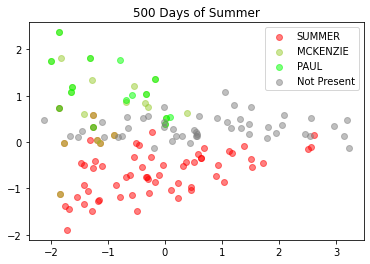

In [85]:
X_extra = []
Y_extra = []
for i in range(1,4):
    X = Xs[i]
    Y = Ys[i]
    X_ = X_s[i]
    Y_  = Y_s[i]
    X_extra.append(X)
    Y_extra.append(Y)
    scatter = plt.scatter(X_, Y_, color = colors[i-1], alpha=0.5, label = real_pro[i])
X = set(X_extra[0])&set(X_extra[1])&set(X_extra[2])
Y = set(Y_extra[0])&set(Y_extra[1])&set(Y_extra[2])
scatter = plt.scatter(list(X), list(Y), color = 'grey', alpha=0.5, label = 'Not Present')
plt.title(name)

plt.legend(scatterpoints=1,loc="upper right")

plt.savefig(name+'_'+ 'side_char'+'.png',dpi=300)  
plt.show()